# 13-1. 들어가며
안녕하세요, 오늘은 시계열 예측(Time-Series Prediction)을 다루는 여러 가지 통계적 기법 중에 가장 널리 알려진 ARIMA(Auto-regressive Integrated Moving Average)에 대해 알아보고 이를 토대로 특정 주식 종목의 가격을 예측해 보는 실습을 진행해 보려고 합니다.

시계열 예측에 사용되는 모델에 ARIMA만 있는 것은 아닙니다. 페이스북에서 발표한 Prophet이라는 것도 있고, LSTM 등 딥러닝을 활용하는 방법도 있습니다. 하지만 ARIMA는 탄탄한 통계학 이론적 기반을 갖추고 있으며, 시계열 데이터를 이해하는 관점을 훈련하는 데에도 도움이 된다는 점에서 한 번쯤 다루어 볼 만한 주제라고 여겨집니다.

그럼 지금부터 시작해 보겠습니다.

## 학습 목표
- 시계열 데이터의 특성과 안정적(Stationary) 시계열의 개념을 이해한다.
- ARIMA 모델을 구성하는 AR, MA, Diffencing의 개념을 이해하고 간단한 시계열 데이터에 적용해 본다.
- 실제 주식 데이터에 ARIMA를 적용해서 예측 정확도를 확인해 본다.

## 목차
### 시계열 예측이란
- 미래를 예측한다는 것은 가능할까?
- Stationary한 시계열 데이터란?
- 시계열 데이터 사례분석
- Stationary 여부를 체크하는 통계적 방법

### ARIMA 시계열 예측
- 시계열 예측의 기본 아이디어 : Stationary하게 만들 방법은 없을까?
- ARIMA 모델의 개념
- ARIMA 모델 훈련과 추론

### 프로젝트 : 주식 예측에 도전해 보자

# 13-2. 시계열 예측이란(1) 미래를 예측한다는 것은 가능할까?
남들보다 미래의 정보를 단 한 시간만이라도 먼저 알 수 있다면 어떨까요? 타임머신 같은 공상과학 영화 시나리오를 생각하지 않더라도, 분초 단위로 거래 가격이 변동하는 주식시장이나 외환거래 시장에서 이런 능력이 얼마나 큰 수익을 가져다줄지는 자명합니다. 꼭 돈 버는 문제를 생각지 않더라도, 각종 산업현장에서 혹시 모를 위험을 미리 감지해서 대비할 수만 있다면 얼마나 유용할까요?

아래와 같은 미래 예측 시나리오를 생각해 봅시다.

- 지금까지의 주가변곡선을 바탕으로 다음 주가변동 예측    
- 특정 지역의 기후데이터를 바탕으로 내일의 온도변화 예측    
- 공장 센터데이터 변화이력을 토대로 이상 발생 예측    

위 예시의 공통점이 무엇일까요? 바로 예측의 근거가 되는 시계열(Time-Series) 데이터가 있다는 것입니다. 시계열이란 시간 순서대로 발생한 데이터의 수열이라는 뜻입니다. 굳이 간단한 수식의 형태를 빌리자면 아래와 같이 표현될 것입니다.

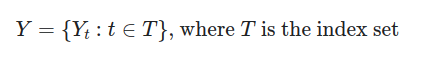

일정 시간 간격으로 발생한 데이터일 때가 많지만 꼭 그래야만 하는 것은 아닙니다. 매일의 주식 거래 가격을 날짜-가격 형태로 날짜순으로 모아둔 데이터가 있다면 훌륭한 시계열 데이터가 될 것입니다. 이때 날짜가 인덱스(index) 역할을 하게 됩니다.

그렇다면 여기서 의문이 생깁니다. 특정 주식의 오늘까지의 매일 가격 변동 시계열 데이터가 수년 치 쌓여 있다고 칩시다. 그럼 우리는 이 데이터를 토대로 내일의 이 주식 가격이 얼마가 될지, 심지어 오를지 내릴지조차, 예측이 가능한 것일까요? 결론적으로 말하자면, 미래 예측은 불가능한 것입니다. 그럼에도 불구하고 미래의 데이터를 예측하려 든다면 적어도 다음 두 가지의 전제가 필요합니다.
```
과거의 데이터에 일정한 패턴이 발견된다.
과거의 패턴은 미래에도 동일하게 반복될 것이다.
```

여기서 안정적(Stationary)이다는 것은 시계열 데이터의 통계적 특성이 변하지 않는다는 뜻입니다. 좀 더 직관적으로 표현하자면, 시계열 데이터를 만들어내는 시간의 변화에 무관하게 일정한 프로세스가 존재한다는 뜻입니다. 매우 불규칙해 보이는 매일의 날씨 변화에도 불구하고 연 단위 기후 변화의 일정한 패턴이 유지된다면, 지구상의 일정한 기후변동 프로세스가 만들어 내는 안정성(stationarity)에 의해 내일의 기온은 어느 정도 오차 범위 내에서 예측이 가능할 것입니다.

https://news.einfomax.co.kr/news/articleView.html?idxno=4082410
#### Q1. 유가 변화를 예측하는데 위성사진 등 추가적인 데이터를 활용하고 있다면 이것 또한 시계열 데이터 예측에 해당할까요?
유가 변화 예측을 위해 과거의 유가 변동 데이터만을 활용했다면 시계열 데이터 예측이라고 볼 수 있지만, 유가 예측에 유가가 아닌 다른 성격의 데이터가 추가로 활용된다면 엄밀한 의미의 시계열 데이터 예측은 아닙니다.

#### Q2. 유가 변화 예측을 위해 이전의 유가 변화 데이터만 활용하지 않고 다른 데이터를 추가로 활용하는 이유는 무엇일까요?
유가 예측을 위해 이전 유가만을 활용하는 시계열 데이터 분석은 원유 시장이 외부적인 영향을 받지 않고 자체적으로 유가를 결정하는 안정적인 프로세스가 존재한다는 것을 전제로 합니다. 말하자면 국제 수요-공급 균형에 기반한 시장원리에 의해 원유시장이 안정적인 평형 상태를 유지한다는 것이지요. 
하지만 국제 유가는 국가 간 분쟁, 경제 호황/불황 등 다양한 외부적 요소에 의해 가격을 결정하는 수요-공급 균형점이 변화하므로, 외부적 요인을 추가로 고려할 수 있는 보조 데이터의 활용이 정확한 예측에 도움이 됩니다.

시계열 데이터 분석은 완벽한 미래 예측을 보장하지는 않습니다. 어떤 예측하지 못한 외부적 변수에 의해 시계열 데이터 분석의 전제가 되는 안정성(stationarity)이 훼손될 여지가 있기 때문입니다. 그럼에도 불구하고, 시계열 데이터 분석은 프로세스 내재적인 시간적 변화를 묘사하는데 아주 훌륭한 성능을 보입니다. 그럼 다음 스텝에서 시계열의 안정적(Stationary)인 특성이란 무엇인지 좀 더 구체적으로 살펴보겠습니다.

# 13-3. 시계열 예측이란(2) Stationary한 시계열 데이터
안정적 시계열(Stationary Time-Series) 데이터의 수학적으로 엄밀한 정의보다는, 아래 링크에서 소개하는 직관적인 정의가 더 도움이 됩니다. 현실적으로 다루는 시계열 데이터는 이런 직관적인 안정성의 정의를 만족하는 정도면 충분히 ARIMA 등의 시계열 모델을 통해 분석이 용이하기 때문입니다.
```
(참고) 'Stationary Time-Series'와 'Stationarity'를 많은 문헌에서 '정상시계열', '정상성'이라는 단어로 번역하기도 합니다. 본 노드에서는 직관적 이해에 보다 도움이 되는 '안정적 시계열', '안정성'이라는 번역을 채택하였습니다. 용어 활용과 관련하여 참고해 주세요.
```

안정적인 시계열의 3가지 요건
http://www.dodomira.com/2016/04/21/arima_in_r/

#### Q3. 안정적인 시계열에서 시간의 추이와 관계없이 일정해야 하는 통계적 특성 세 가지는 무엇인가요?
평균, 분산, 공분산(그러나 정확히는 자기공분산-autocovariance이라고 해야 함)



Covariance와 Correlation
https://destrudo.tistory.com/15

#### Q4. 두 확률변수 X, Y 변수의 분포가 서로 얼마나 상관성을 가지는지를 나타내는 지표라는 점에서 Covariance와 Correlation은 비슷한 개념입니다. 그렇다면 두 개념은 어떤 점에서 다른가요?
Covariance가 X, Y 변수의 단위 크기에 영향을 받기 때문에 그 값 자체가 두 변수 간의 상관성을 직접적으로 대표하지 못한다. 그래서 Covariance를 두 변수의 표준편차의 곱으로 나눠서(Covariance를 Normalize하여) 두 변수 간의 상관성이 항상 -1에서 1 사이의 값으로 표현되도록 보정한 것이 Correlation이다.

#### Q5. 만약 X와 X의 Covariance를 계산한다면 이것은 다음 중 무엇과 같아지나요?
 1) 평균(Mean)  2) 분산(Variance)  3) 표준편차(Standard Deviation)  4) 상관계수(Correlation)      
[분산(Variance)]
 

#### Q6. 두 확률변수 X, Y가 서로 독립이면 Covariance와 Correlation은 어떻게 되나요?
Covariance와 Correlation은 모두 0이다     
https://m.blog.naver.com/sw4r/221030974616

#### Q7. 자기와의 공분산이라면 그냥 분산이 되는데, 분산이라고 하지 않고 자기공분산이라고 하는 이유는 무엇인가요?
X(t)와 X(t) 사이의 공분산이 아니라 X(t)와 X(t+h) 사이의 공분산이기 때문. 즉 일정 시차 h 사이를 둔 자기자신과의 공분산이기 때문이다.

#### Q8. X(t)와 X(t+h) 사이의 공분산과 X(t-h)와 X(t) 사이의 공분산은 항상 일정한가요? 아니면 어떤 조건 하에서만 성립하나요?
X가 Stationary한 시계열 변수라는 조건 하에서만 성립한다. 즉, 안정적인 시계열에 한해서 시차 h가 같다면  데이터의 상관성이 동일한 주기성이 나타난다.

이제 다시 안정적 시계열이 가져야 할 요건으로 돌아와 보겠습니다. 우리는 과거 몇 개의 데이터를 통해 다음 데이터를 예측해 보려고 합니다. 예를 들어 직전 5년 치 판매량 X(t-4), X(t-3), X(t-2), X(t-1), X(t)를 가지고 X(t+1)이 얼마일지 예측을 해보고 싶다고 합시다.

이 예측이 의미가 있으려면 중요한 것은 t에 무관하게 이 예측이 맞아떨어져야 한다는 점입니다. t=2010일 때의 데이터를 가지고 X(2011)을 정확하게 예측하는 모델이라면 이 모델에 t=2020을 대입해도 이 모델이 X(2021)을 정확하게 예측할 수 있어야 한다는 것입니다. 그러려면 t에 무관하게 X(t-4), X(t-3), X(t-2), X(t-1), X(t)의 평균과 분산이 일정 범위 안에 있어야 합니다. 또한 X(t-h)와 X(t)는 t에 무관하게 h에 대해서만 달라지는 일정한 상관도를 가져야 합니다. 그렇지 않으면 우리의 시계열 예측은 t에 따라 달라지는, '그때그때 달라요' 예측이 됩니다. 이것은 '과거의 패턴이 미래에도 반복될 것이다'라는 시계열 예측의 대전제를 무너뜨립니다.

# 13-4. 시계열 예측이란(3) 시계열 데이터 사례분석
이번 스텝에서는 잘 알려진 작은 시계열 데이터를 토대로 시계열 데이터의 안정성의 개념을 시각적으로 따져보겠습니다.

우선 아래와 같이 데이터를 준비해 주세요.
```
$ mkdir -p ~/aiffel/stock_prediction/data
$ wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
$ wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
$ mv daily-min-temperatures.csv airline-passengers.csv ~/aiffel/stock_prediction/data

```

## 시계열(Time Series) 생성
첫 번째로 다루어볼 데이터는 Daily Minimum Temperatures in Melbourne입니다. 온도 변화를 다루는 시계열인 만큼 안정성이 있지 않을까요?

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
print('슝=3')

슝=3


In [14]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/daily-min-temperatures.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


Pandas에서 제공하는 Series라는 자료구조가 있었던 것을 기억하시나요? 오늘 다루게 될 시계열(Time Series)이란 것도 결국 시간 컬럼을 index로 하는 Series로 표현됩니다. 우리가 읽어 들인 데이터 파일은 Pandas를 통해 2개의 컬럼을 가진 DataFrame으로 변환되었습니다. 이것은 아직 시계열의 데이터 구조는 아닙니다.

위의 DataFrame에서 Date 컬럼을 index로 삼아 시계열을 생성해 봅시다.

#### 날짜를 인덱스로 설정하는법
```
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True
parse_dates는 날짜를 datetime형태로 변환할지 여부
index_col는 날짜 칼럼
```
    https://soo-jjeong.tistory.com/127


In [15]:
# 이번에는 Date를 index_col로 지정해 주었습니다. 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


시간 컬럼이 index가 되었지만 아직도 type은 DataFrame으로 나옵니다. 우리가 찾는 시계열은 바로 여기 있습니다.

In [16]:
ts1 = df['Temp']
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

DataFrame인 df와 Series인 df['Temp']는 index 구조가 동일하므로 Numpy, Pandas, Matplotlib 등 많은 라이브러리들이 호환해서 지원해 준다. 하지만 그렇지 않은 경우도 간혹 발생하므로 여기서는 명확하게 Series 객체를 가지고 진행하겠다.

## 시계열 안정성의 정성적 분석
이제 시계열이 준비되었으므로 시각화를 통해 안정성(Stationarity) 여부를 확인해 보겠습니다.

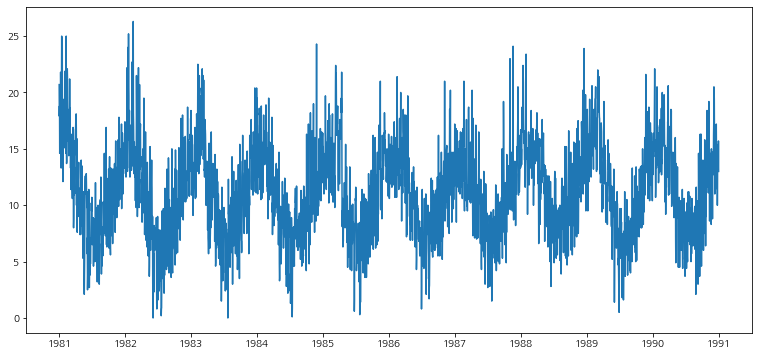

In [17]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts1)

좋습니다. 멋진 차트가 그려졌군요.

하지만 분석에 들어가기 전에 잊지 말아야 할 단계가 하나 있습니다. 바로 결측치 유무 확인입니다.

In [18]:
ts1[ts1.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Temp, dtype: float64)

어떻습니까? 다행히 이 데이터에는 결측치가 없군요. 하지만 혹시 결측치가 있다면 조치가 필요합니다. NaN이 들어있는 데이터는 통계분석 시에 많은 오류를 일으킬뿐더러 분석결과에도 악영향을 미칠 것입니다.

만약 결측치가 있다면, 1)결측치가 있는 데이터를 모두 삭제(drop)하거나, 2)결측치 양옆의 값들을 이용해서 적절히 보간(interpolate) 대입해 주는 방법이 있습니다. 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식인 거죠. 이번 경우라면 시간을 index로 가지는 시계열 데이터이므로 삭제하는 것보다는 보간하는 방법을 선택하겠습니다.

Pandas에서 결측치 보간을 처리하는 메소드는 다음과 같습니다. 상세한 설명은 이 아티클을 참고해 주세요.https://rfriend.tistory.com/264

Series([], Name: Temp, dtype: float64)


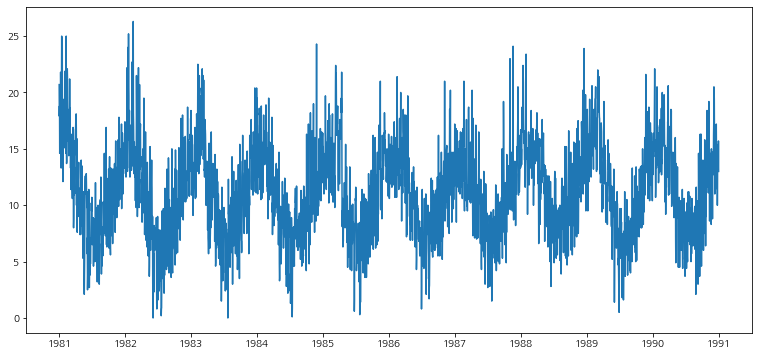

In [19]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts1=ts1.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts1[ts1.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts1)

어떻습니까? 시간 추이에 따라 일정한 평균, 분산, 자기공분산의 패턴이 나타나는 것 같습니까? 직관적으로 그래 보이긴 합니다만, 시계열 데이터의 통계적 특성을 좀 더 명료하게 시각화해 보겠습니다.

아래는 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수입니다. 현재 타임스텝부터 window에 주어진 타임스텝 이전 사이 구간의 평균(rolling mean, 이동평균)과 표준편차(rolling std, 이동표준편차)를 원본 시계열과 함께 시각화해 보면 좀 더 뚜렷한 경향성을 확인할 수 있을 것입니다.

In [20]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


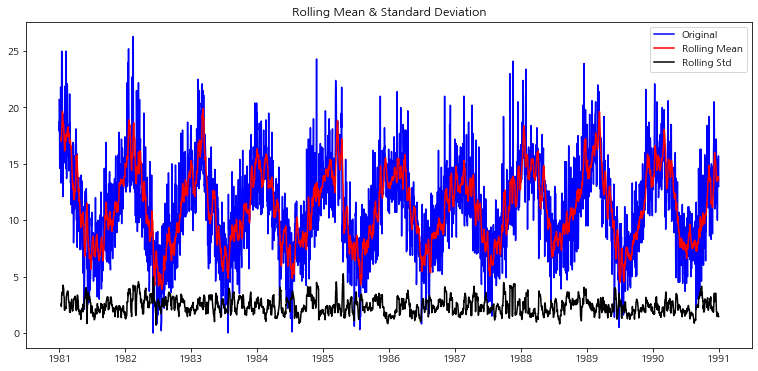

In [21]:
plot_rolling_statistics(ts1, window=12)

이 시계열 데이터가 안정적이라고 명확하게 결론을 내릴 수 있을까요? 시각화한 결과만 놓고 보면 그렇다고 말할수도 있겠습니다만, 명확하게 단정지으려면 좀더 통계적인 접근이 필요할 것입니다. 그건 다음 스텝에서 다루기로 하고, 이번에는 다른 시계열 데이터의 패턴과 비교해 보면 어떨까요?

## 다른 데이터에 대해서도 비교해 보자.

이번에는 <Strong>International airline passengers</Strong> 데이터셋입니다. 월별 항공 승객 수(천명 단위)의 시계열 데이터인데 기온 변화 데이터셋과는 좀 다른 패턴이 나타나지 않을까요? 위와 동일한 방법으로 분석해 보겠습니다.

In [11]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/airline-passengers.csv' 
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)  
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


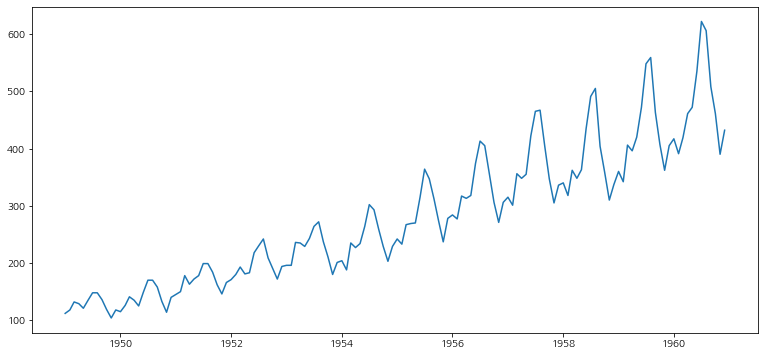

In [12]:
ts2 = df['Passengers']
plt.plot(ts2)

직관적으로 봐도 온도변화 데이터셋과는 다른 패턴이 보입니다. 시간의 추이에 따라 시계열의 평균과 분산이 지속적으로 커지는 패턴을 보입니다. rolling statistics를 추가해서 시각화해 보겠습니다.

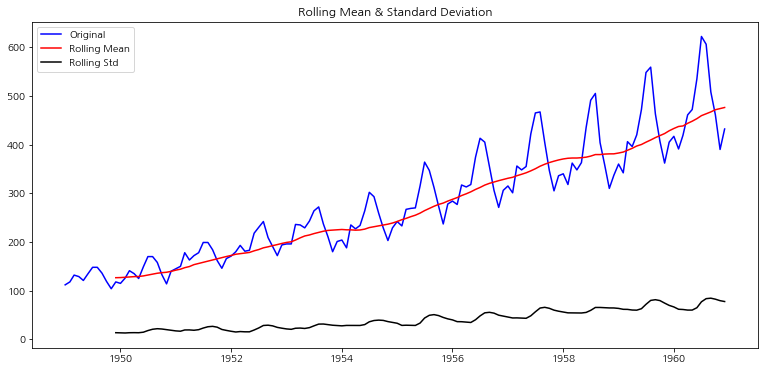

In [13]:
plot_rolling_statistics(ts2, window=12)

이렇게 시간의 추이에 따라 평균과 분산이 증가하는 패턴을 보인다면 이 시계열 데이터는 적어도 안정적이진 않다고 정성적인 결론을 내려볼 수 있을 것 같습니다. 그렇다면 이런 시계열 데이터에 대해서는 시계열 예측을 시도할 수 없는 것일까요? 그렇다면 이번 노드는 너무 재미가 없겠지요? 이후 스텝들에는 이런 불안정적(Non-Stationary) 시계열 데이터에 대한 시계열 분석 기법을 다루어 볼 것입니다.

위와 같이 우리는 시계열 데이터의 안정성을 시각화 방법을 통해 정성적으로 분석해 볼 수 있습니다. 이것은 시계열 데이터를 다루는 가장 기본적인 접근법이라 할 수 있습니다. 하지만 시계열 데이터의 안정성을 평가하는 데는 보다 정량적인 방법이 있을 것 같습니다.

# 13-5. 시계열 예측이란(4) Stationary 여부를 체크하는 통계적 방법

## Augmented Dickey-Fuller Test
------------------------------------------------

이번 스텝에서는 <Strong>Augmented Dickey-Fuller Test(ADF Test)</Strong>라는 시계열 데이터의 안정성을 테스트하는 통계적 방법을 소개하려고 합니다. 이 테스트는 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후, 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다는 내용입니다.

이미 여기까지의 설명만으로도 머리가 굳어버리는 느낌을 받으실 수도 있을 것 같습니다. 시계열 분석은 탄탄한 통계학적 기반에 입각한 만큼 제대로 이해하기 위해서는 전문적인 훈련이 필요합니다. 그래서 ADF Test의 세부 알고리즘은 생략하고, statsmodels 패키지에서 제공하는 adfuller 메소드를 이용해 손쉽게 ADF Test의 결과를 이용할 것입니다. 하지만 세부 알고리즘을 좀더 파악하고 싶으시다면 Unit Root Test의 개념으로부터 ADF Test에 대한 설명으로 이어지는 이 글을 추천합니다.https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

하지만 통계적 가설 검정의 기본 개념을 이루는 p-value 등의 용어에 대해서는 한 번쯤 짚고 넘어가는 것이 이후 과정의 이해를 도울 것이라고 판단됩니다. 다음 링크의 글들을 읽고 질문에 답해 보세요.

유의확률-위키백과   https://ko.wikipedia.org/wiki/%EC%9C%A0%EC%9D%98_%ED%99%95%EB%A5%A0
P-value(유의확률)의 개념     
https://m.blog.naver.com/baedical/10109291879

#### Q9. p-value(유의확률)이란 어떤 의미인가요?
p-value의 정의는 귀무가설을 가정했을 때의 확률분포 상에서 현재의 관측보다 더 극단적인 관측이 나올 확률로서, 귀무가설의 가정이 틀렸다고 볼 수 있는 확률이기도 하다. 이 값이 0.05 미만으로 매우 낮게 나온다면 p-value만큼의 오류 가능성 하에 귀무가설을 기각하고 대립가설을 채택할 수 있는 근거가 된다.

## statsmodels 패키지와 adfuller 메소드
------------------------------------------------
statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지입니다. 이번 노드에서는 statsmodels 패키지의 기능을 자주 활용하게 될 것입니다. 아래는 statsmodels 패키지에서 제공하는 adfuller 메소드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드입니다.

아래 코드를 수행하기 위해 먼저 다음과 같이 statsmodels 패키지를 설치합니다.
```
$ pip install statsmodels
```

In [22]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


그럼 이전 스텝에서 정성적으로 분석해 보았던 두 시계열(Time Series)에 대한 Augmented Dickey-Fuller Test를 수행해 봅시다.

In [15]:
#Daily Minimum Temperatures in Melbourne 시계열
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


<strong>Daily Minimum Temperatures in Melbourne</strong> 시계열이 안정적이지 않다는 귀무가설은 p-value가 거의 0에 가깝게 나타났습니다. 따라서 이 귀무가설은 기각되고, 이 시계열은 안정적 시계열이라는 대립가설이 채택됩니다.

In [16]:
#International airline passengers 시계열
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


<strong>International airline passengers</strong> 시계열이 안정적이지 않다는 귀무가설은 p-value가 거의 1에 가깝게 나타났습니다. 이것이 바로 이 귀무가설이 옳다는 직접적인 증거가 되지는 않지만, 적어도 이 귀무가설을 기각할 수는 없게 되었으므로 이 시계열이 안정적인 시계열이라고 말할 수는 없습니다.

# 13-6. 시계열 예측의 기본 아이디어 : Stationary하게 만들 방법은 없을까?
이제 우리는 위에서 안정적이라고 말할 수 없게 된 <strong>International airline passengers</strong> 시계열을 조금 더 분석해 보겠습니다. 이전 스텝에서도 언급했듯, 안정적이지 않은 시계열을 분석하려면 이것을 안정적인 시계열로 바꾸어 내야 합니다. 이것이 어떻게 가능할까요?

크게 두 가지를 언급할 것입니다. 한가지는 정성적인 분석을 통해 보다 안정적(starionary)인 특성을 가지도록 기존의 시계열 데이터를 가공/변형하는 시도들이고, 다른 하나는 시계열 분해(Time series decomposition)라는 기법을 적용하는 것입니다.

# 보다 Stationary한 시계열로 가공해 가기

### 로그함수 변환
가장 먼저 고려해 볼 수 있는 것은 시간 추이에 따라 분산이 점점 커지고 있다는 점입니다. 시계열이 이런 특성을 보일 경우에는 로그함수로 변환을 해주는 것이 도움이 됩니다.

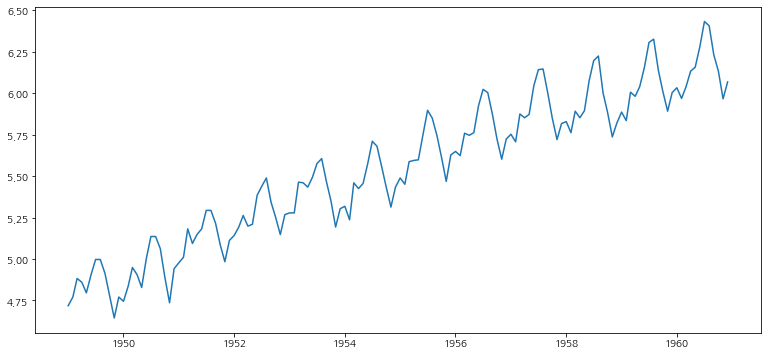

In [17]:
ts_log = np.log(ts2)
plt.plot(ts_log)

로그 변환의 효과가 어떠했는지 따져 보기 위해 Augmented Dickey-Fuller Test를 수행해 봅시다.

In [18]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


p-value가 0.42로 무려 절반 이상 줄어들었습니다. 정성적으로도 시간 추이에 따른 분산이 일정해진 것을 확인할 수 있습니다. 아주 효과적인 변환이었던 것 같습니다. 하지만 아직은 갈 길이 멉니다. 가장 두드러지는 문제점은 시간 추이에 따라 평균이 계속 증가한다는 점입니다.

#### Moving average 제거 - 추세(Trend) 상쇄하기
시계열 분석에서 위와 같이 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 합니다. 이 변화량을 제거해 주려면 거꾸로 Moving Average, 즉 rolling mean을 구해서 ts_log에서 빼주면 어떨까요?

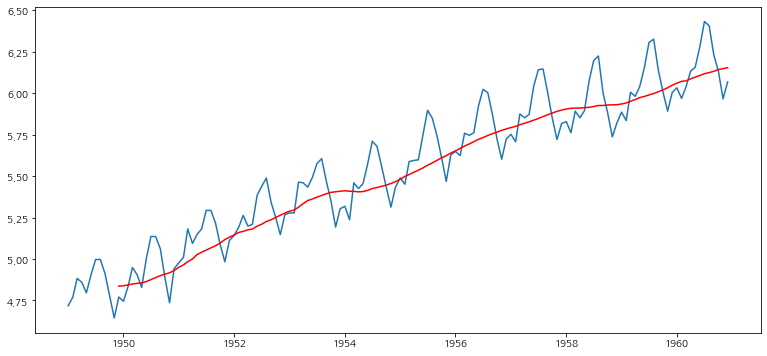

In [19]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [20]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

우리가 관심을 가진 ts_log_moving_avg에 거의 도달했습니다. 그런데 문제는 Moving Average 계산 시 (windows size=12인 경우) 앞의 11개의 데이터는 Moving Average가 계산되지 않으므로 ts_log_moving_avg에 결측치(NaN)가 발생한다는 점입니다.
이 결측치들은 향후 Dicky-Fuller Test 시에 에러를 발생시킬 것이므로 이를 데이터셋에서 제거해 줍니다.

In [21]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

우리가 관심을 가진 ts_log_moving_avg에 거의 도달했습니다. 그런데 문제는 Moving Average 계산 시 (windows size=12인 경우) 앞의 11개의 데이터는 Moving Average가 계산되지 않으므로 ts_log_moving_avg에 결측치(NaN)가 발생한다는 점입니다.
이 결측치들은 향후 Dicky-Fuller Test 시에 에러를 발생시킬 것이므로 이를 데이터셋에서 제거해 줍니다.

In [22]:
#결측치 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

이제 이전 스텝에서 정의했던 메소드들을 활용하여 ts_log_moving_avg를 정성, 정량적으로 분석해 봅시다.

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


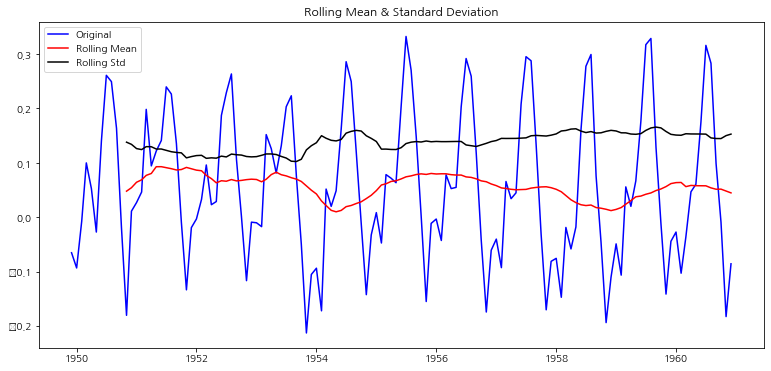

In [23]:
plot_rolling_statistics(ts_log_moving_avg)

In [24]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


드디어 p-value가 0.02 수준이 되었습니다. 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있겠습니다.

그러나 지금까지의 접근에서 한가지 숨겨진 문제점이 있습니다.
바로 Moving Average를 계산하는 window=12로 정확하게 지정해 주어야 한다는 점입니다.

만약 위 코드에서 window=6을 적용하면 어떤 결과가 나올까요?

In [25]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)
print('슝=3')

슝=3


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


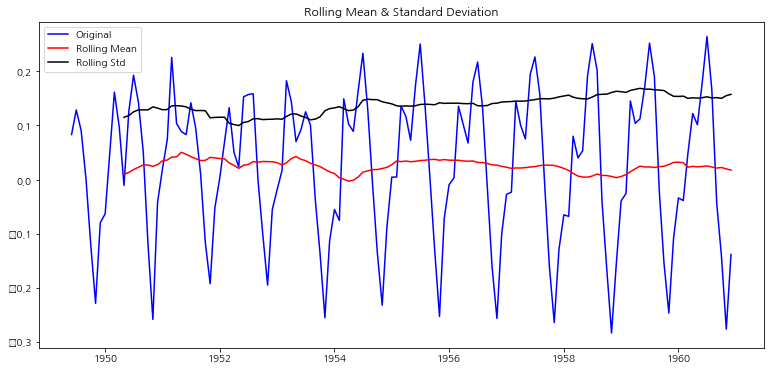

In [26]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [27]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -2.273822
p-value                          0.180550
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


그래프를 정성적으로 분석해서는 window=12일 때와 별 차이를 느낄수 없지만 Augmented Dickey-Fuller Test의 결과 p-value는 0.18 수준이어서 아직도 안정적 시계열이라고 말할 수 없게 되었습니다.

이 데이터셋은 월 단위로 발생하는 시계열이므로 12개월 단위로 주기성이 있기 때문에 window=12가 적당하다는 것을 추측할 수도 있을 것 같습니다만, <strong>moving average를 고려할 때는 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요하다는 것을 기억해 둡시다</strong>

이제 시간의 추이에 따라 평균이 증가하는 trend를 제거하였습니다. 그러나 여전히 안정적인 시계열이라고 하기에는 마음에 걸리는 부분이 있습니다.

### 차분(Differencing) - 계절성(Seasonality) 상쇄하기

Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소입니다. 이것은 Moving Average 제거로는 상쇄되지 않는 효과입니다. 이런 계절적, 주기적 패턴을 계절성(Seasonality)라고 합니다.

이런 패턴을 상쇄하기 위해 효과적인 방법에는 차분(Differencing)이 있습니다. 마치 미분(Differentiation)을 떠올리게 하는 개념인데요, 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법입니다. 이렇게 되면 남은 것은 현재 스텝 값 - 직전 스텝 값이 되어 정확히 이번 스텝에서 발생한 변화량을 의미하게 됩니다. 이 변화량 시계열은 어떤 패턴을 보이게 될까요?

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


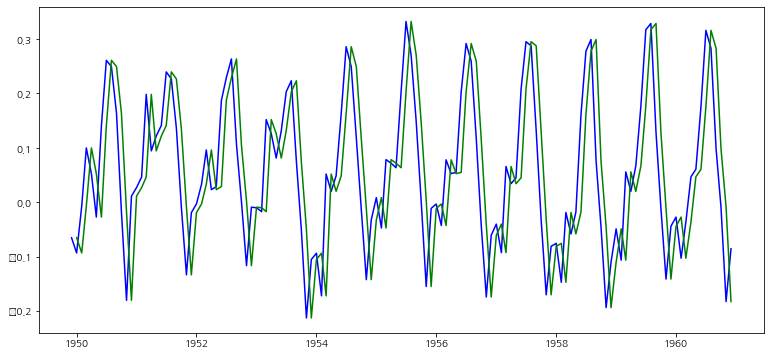

In [28]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

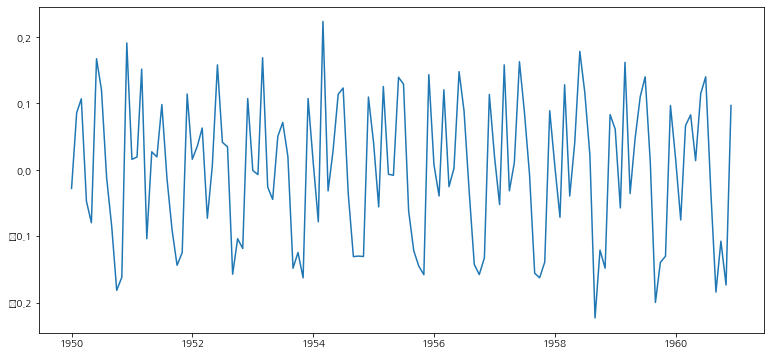

In [29]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

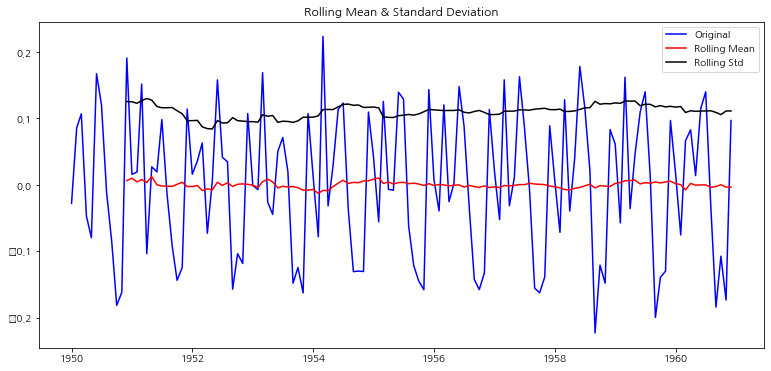

In [30]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [31]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


Trend를 제거하고 난 시계열에다가 1차 차분(1st order differencing)을 적용하여 Seasonality 효과를 다소 상쇄한 결과, p-value가 이전의 10% 정도까지로 줄어들었습니다. 데이터에 따라서는 2차 차분(2nd order differencing, 차분의 차분), 3차 차분(3rd order differencing, 2차 차분의 차분)을 적용하면 더욱 p-value를 낮출 수 있을지도 모릅니다.

### 시계열 분해(Time series decomposition)

statsmodels 라이브러리 안에는 <strong>seasonal_decompose</strong> 메소드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있습니다. 이 기능을 활용하면 우리가 위에서 직접 수행했던 moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼 수 있게 됩니다. 이번에는 위에서 구했던 로그변환 단계(ts_log)에서부터 출발해 봅시다.

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


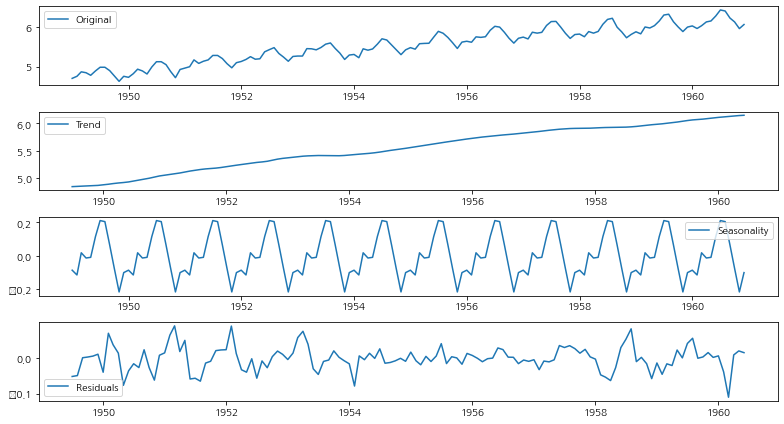

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 합니다. 뒤집어서 말하면 Trend+Seasonality+Residual=Original 이 성립한다는 뜻입니다. 이러한 Decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시해 줍니다.

그렇다면 이제 Residual에 대해 안정성 여부를 따져 봅시다.

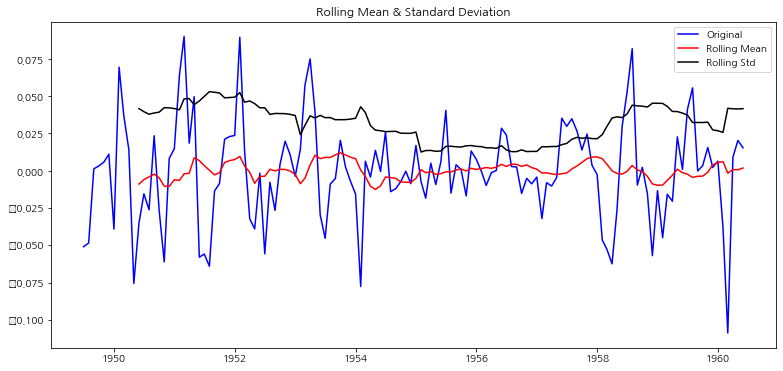

In [34]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [35]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 줍니다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다. 어쩌면 굳이 애써 직접 Trend, Seasonality를 제거하려고 애쓸 필요가 없이 바로 Time Series Decomposing을 시도하는 게 더 낫지 않았을까요? 물론 그렇긴 합니다만, 이렇게 Trend와 Seasonality를 제거해 주는 것이 어떤 효과를 발휘하게 되는지를 단계적으로 확인하는 과정이었다고 이해해 주시면 좋겠습니다.

# 13-7. ARIMA 모델의 개념
## ARIMA 모델의 정의
-----------------------------------

이전 스텝에서 우리는 시계열 데이터가 Trend와 Seasonality와 Residual로 Decompose되며, Trend와 Seasonality를 효과적으로 분리해 낸 경우 아주 예측력 있는 안정적인 시계열 데이터로 변환 가능하다는 것을 확인하였습니다.

바로 이런 원리를 활용하여 시계열 데이터 예측모델을 자동으로 만들어 주는 모델이 있습니다. 바로 오늘 소개하게 될 ARIMA(Autoregressive Integrated Moving Average)입니다.

ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average)가 합쳐진 모델입니다. 각각의 개념을 하나하나 살펴보면 바로 지금까지 우리가 다루어온 개념들과 닮아 있음을 알게 됩니다.

시계열 데이터 
Y={Yt:t∈T} 를 생각해 봅시다.Yt 를 예측하기 위해서 다음과 같은 모델들을 생각해 볼 수 있습니다.

### AR(자기회귀, Autoregressive)

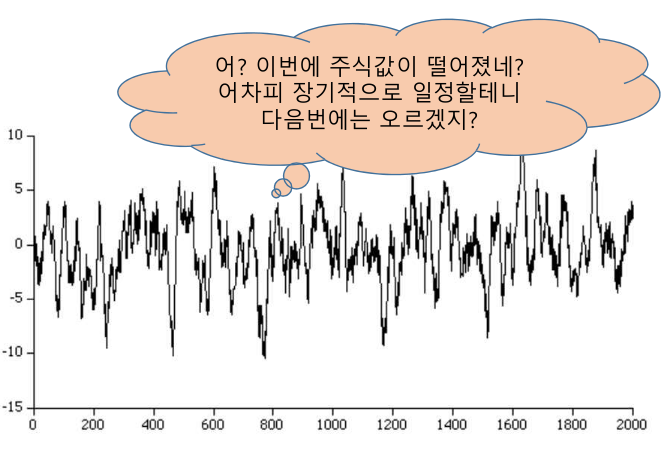

- 자기회귀(AR)란 Yt가 이전 p개의 데이터 Yt−1,Yt−2,...,Yt−p 의 가중합으로 수렴한다고 보는 모델입니다.
- 가중치의 크기가 1보다 작은 Yt−1,Yt−2,...,Yt−p 의 가중합으로 수렴하는 자기회귀 모델과 안정적 시계열은 통계학적으로 동치입니다.
- AR은 일반적인 시계열에서 Trend와 Seasonality를 제거한 Residual에 해당하는 부분을 모델링한다고 볼 수 있습니다.
- 주식값이 항상 일정한 균형 수준을 유지할 것이라고 예측하는 관점이 바로 주식 시계열을 AR로 모델링하는 관점이라고 볼 수 있습니다.

### MA(이동평균, Moving Average)

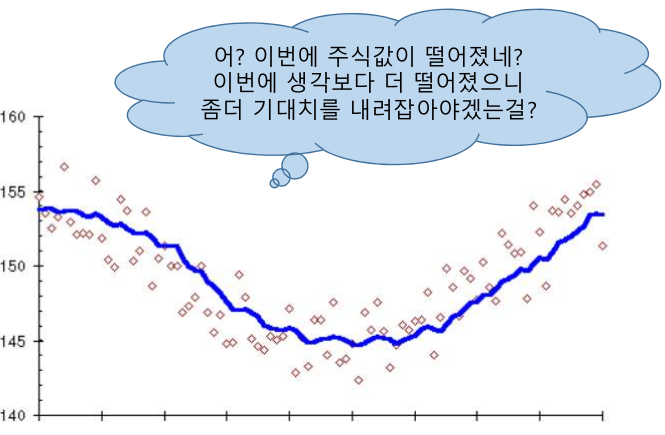

- 이동평균(MA)은 Yt가 이전 q개의 예측오차값et−1,et−2,...,et−q 의 가중합으로 수렴한다고 보는 모델입니다.
- MA는 일반적인 시계열에서 Trend에 해당하는 부분을 모델링한다고 볼 수 있습니다. 예측오차값 
et−1이 +라면 모델 예측보다 관측값이 더 높았다는 뜻이므로, 다음 Yt 예측 시에는 예측치를 올려잡게 됩니다.
- 주식값은 항상 최근의 증감 패턴이 지속될 것이라고 예측하는 관점이 바로 주식 시계열을 MA로 모델링하는 관점이라고 볼 수 있습니다.

### I (차분누적, Integration)
- 차분누적은 Yt이 이전 데이터와 d차 차분의 누적(integration) 합이라고 보는 모델입니다.
- 예를 들어서 d=1이라면Yt는Yt−1과ΔYt−1 의 합으로 보는 것입니다.
- I는 일반적인 시계열에서 Seasonality에 해당하는 부분을 모델링한다고 볼 수 있습니다.
ARIMA는 위 3가지 모델을 모두 한꺼번에 고려하는 모델입니다. 주식값을 예측하는 우리의 태도와 비슷하지 않나요? 위 그림에서 보듯 어제 주식값이 떨어졌다는 것을 알게 되었을 때, '오늘은 주식이 올라서 균형을 맞추겠지?'라는 AR 형태의 기대와 '어제 떨어졌으니 추세적으로 계속 떨어지지 않을까?'라는 MA 형태의 우려가 동시에 떠오르게 됩니다. ARIMA는 이 두 모델 사이에서 적정 가중치를 찾아가는 훨씬 통합적인 예측 능력을 보여 줍니다.



## ARIMA 모델의 모수 p, q, d

ARIMA를 활용해서 시계열 예측 모델을 성공적으로 만들기 위해서는 ARIMA의 모수(parameter)를 데이터에 맞게 설정해야 합니다. 쉽게 말하자면 모델에 아주 핵심적인 숫자들을 잘 설정해야 올바른 예측식을 구할 수 있다는 것이지요.

ARIMA의 모수는 3가지가 있는데, 자기회귀 모형(AR)의 시차를 의미하는 p, 차분(diffdrence) 횟수를 의미하는 d, 이동평균 모형(MA)의 시차를 의미하는 q입니다.

이들 중 p 와 q 에 대해서는 통상적으로 p + q < 2, p * q = 0 인 값들을 사용하는데, 이는 p 나 q 중 하나의 값이 0이라는 뜻입니다. 이렇게 하는 이유는 실제로 대부분의 시계열 데이터는 자기회귀 모형(AR)이나 이동평균 모형(MA) 중 하나의 경향만을 강하게 띠기 때문입니다.

그러면 ARIMA(p,d,q) 모델의 모수를 결정하는 방법은 어떻게 될까요? 예를 들어 q라면 이전 스텝에서 Moving Average를 구할 때의 window=12에 해당하는 값과 같은 역할을 한다는 느낌이 듭니다. 이 값을 어떻게 결정하느냐가 시계열 데이터의 안정성 및 이후 예측성능에 영향을 크게 미칠 것입니다.

여기서부터의 설명이 매우 어렵습니다. ARIMA의 적절한 모수 p,d,q를 선택하기 위한 방법에는 엄청난 통계학적인 다양한 시도들이 있습니다. 통계학적인 설명을 생략하고 결론부터 이야기하자면, 모수 p,d,q는 ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)을 통해 결정할 수 있습니다. 이 AutoCorrelation은 우리가 맨 첫 스텝에서 만났던 바로 개념 중 하나인 자기상관계수와 같은 것입니다.

ACF 는 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수이며, PACF 는 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수입니다.

지난 스텝에서 다루었던 International airline passengers 시계열을 토대로 예시를 들어 설명하겠습니다. 우리는 statsmodels에서 제공하는 ACF와 PACF 플로팅 기능을 사용할 것입니다.

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


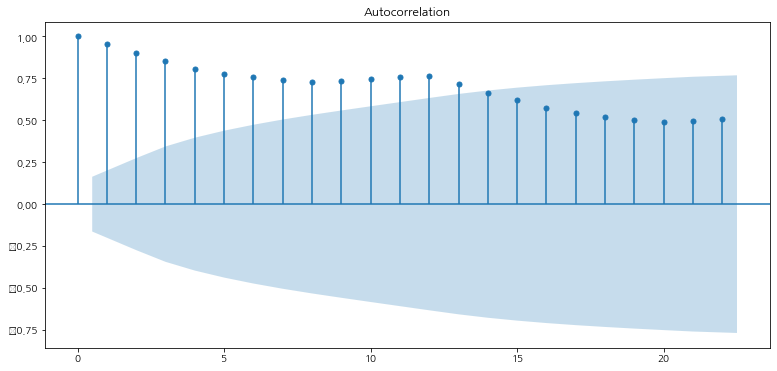

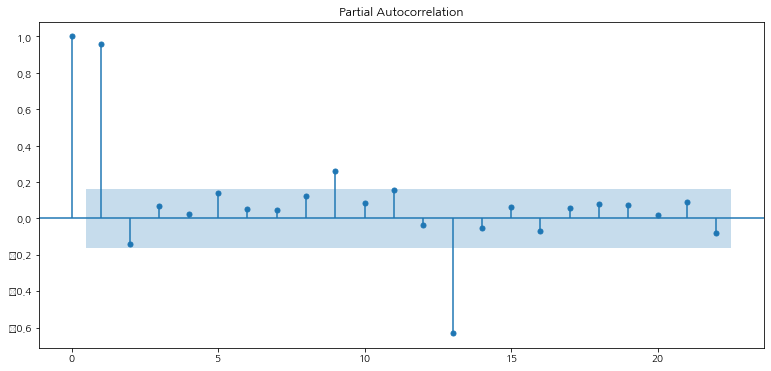

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

아래 그림은 ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있음을 통계학적으로 설명하는 아티클에서 요약결론 부분만 가져온 것입니다.

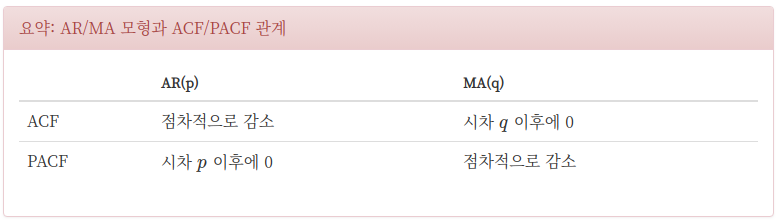

이 결론에 따라 보자면 PACF 그래프를 볼 때 p=1이 매우 적합한 것 같습니다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문입니다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.
반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있습니다. q에 대해서는 적합한 값이 없어 보입니다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있습니다. 하지만 q를 바꿔 가면서 확인해 보는 것도 좋겠습니다.

d를 구하기 위해서는 좀 다른 접근이 필요합니다. d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 보아야 합니다.

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


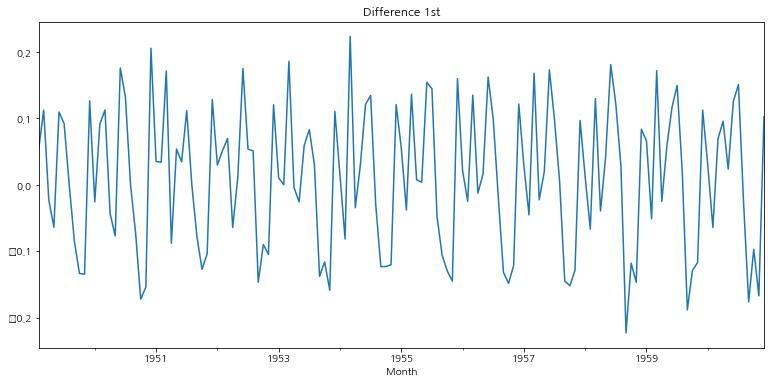

In [38]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


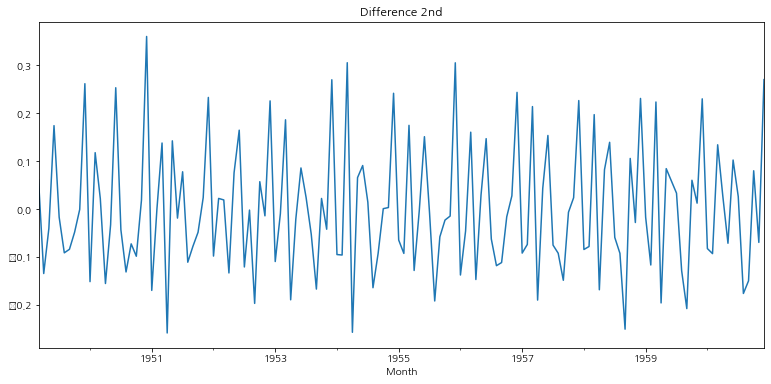

In [39]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

이번 경우에는 1차 차분을 구했을 때 약간 애매한 수준의 안정화 상태를 보였습니다. 2차 차분을 구했을 때는 확실히 안정화 상태였지만 이번 경우에는 d=1로 먼저 시도해 볼 수 있을 것 같습니다. d 값도 바꿔 가면서 최적의 값을 찾아보기를 권합니다.

## 학습데이터 분리

아래와 같이 시계열 데이터에서 학습 데이터와 테스트 데이터를 분리해 봅시다. 분리 비율은 학습과 테스트에 9:1로 하겠습니다. 시계열 예측이니만큼 가장 나중 데이터를 테스트용으로 사용하는 것이 타당할 것입니다.

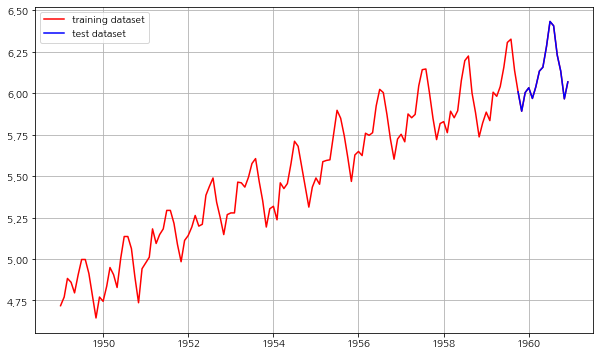

In [40]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

아래와 같이 데이터셋의 형태를 확인해 봅시다.

In [41]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


# 13-8. ARIMA 모델 훈련과 추론
위에서 우리는 일단 p=1, d=1, q=0을 모수로 가지는 ARIMA 모델을 우선적으로 고려하게 되었습니다. ARIMA 모델을 훈련하는 것은 아래와 같이 간단합니다.

In [42]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  128
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 108.023
Method:                       css-mle   S.D. of innovations              0.104
Date:                Mon, 01 Mar 2021   AIC                           -210.046
Time:                        01:33:46   BIC                           -201.490
Sample:                    02-01-1949   HQIC                          -206.570
                         - 09-01-1959                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0108      0.011      0.972      0.331      -0.011       0.033
ar.L1.D.Passengers     0.1754      0.088      1.994      0.046       0.003       0.348
                    

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency inf

훈련데이터에 대해 ARIMA 모델이 잘 fit하는지 시각적으로 확인해 보겠습니다.

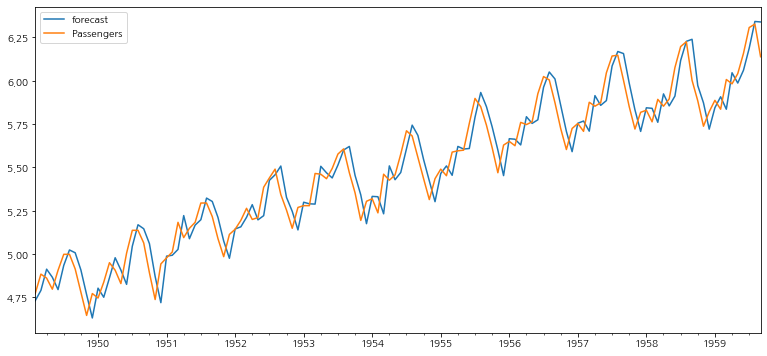

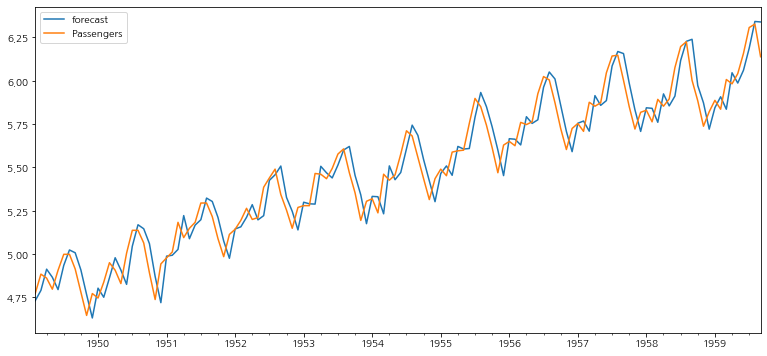

In [43]:
fitted_m.plot_predict()

forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측해 봅니다.

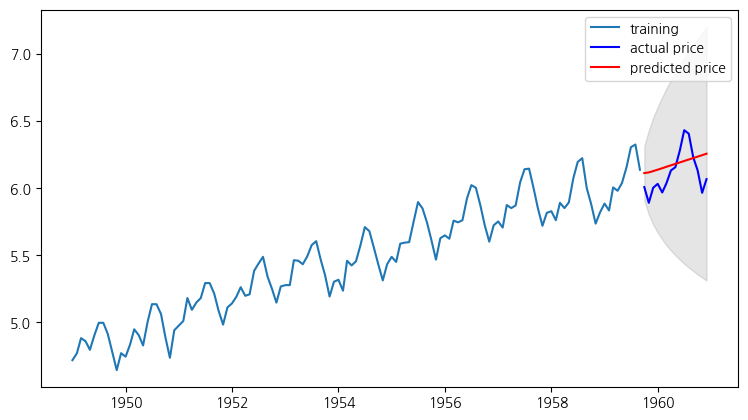

In [44]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

최종적인 모델의 오차율을 계산하려면, 그동안 로그 변환된 시계열을 사용해 왔던 것을 모두 지수 변환하여 원본의 스케일로 계산해야 타당합니다. np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산해 보았습니다.

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5409.550103512347
MAE:  63.136923863759435
RMSE:  73.54964380275644
MAPE: 14.08%


최종적으로 예측 모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 14% 정도의 오차율을 보입니다. 썩 만족스럽지 않은데, 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을지 모르겠습니다. q=8을 줄 경우 MAPE가 10% 정도로 내려갑니다. q=12를 쓸 수 있다면 더욱 좋을 거라는 예상이 되지만 이번 경우에는 데이터셋이 너무 작아 쓸 수 없었습니다.

다음 스텝에서 훨씬 크고 실전적인 데이터셋에 도전해 봅시다!


Mean absolute percentage error
https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

# 13-9. 프로젝트 : 주식 예측에 도전해 보자
ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았습니다. 이제 실제 주식값 예측에 도전해 봅시다. 데이터는 과거의 일자별 시세이며, 다음의 그림과 같이 Yahoo Finance에서 아래 그림을 따라 하시면 다운로드할 수 있습니다.
https://finance.yahoo.com/

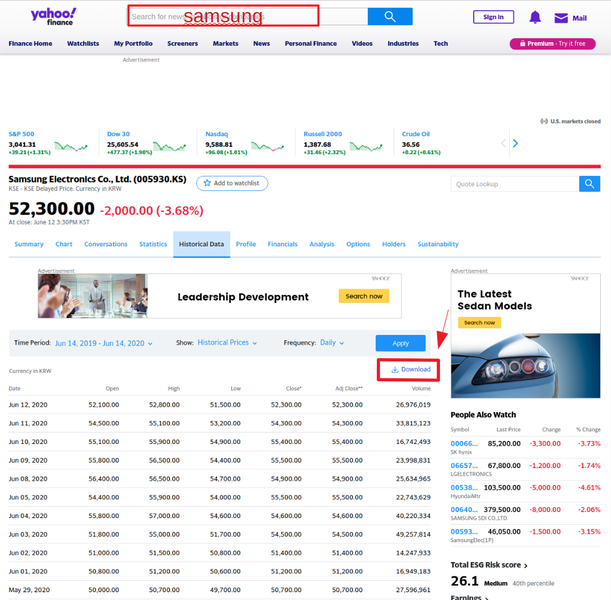

우선 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해 봅시다. 이를 위해서 "samsung"을 검색하시고, "Historical Data" 탭에서 "Time Period"를 "Max"로 선택, "Apply" 버튼을 눌러 과거 삼성전자가 상장한 시점부터 가장 최근까지의 자료를 조회합니다. 그리고 "Download"를 클릭하면 데이터를 다운로드를 할 수 있습니다. 다운로드가 완료되었다면 대략 다음과 같이 작업 디렉토리로 파일을 옮겨 주세요. 실습환경에 따라 원본(source)과 사본(destination) 경로는 달라질 수 있습니다.

```
$ mv ~/다운로드/005930.KS.csv ~/aiffel/stock_prediction/data
# 환경설정을 영어로 사용하는 경우는 아래 명령어를 입력하세요.
$ mv ~/Downloads/005930.KS.csv ~/aiffel/stock_prediction/data

```

# STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-03-02    55000.0
2020-03-03    55400.0
2020-03-04    57400.0
2020-03-05    57800.0
2020-03-06    56500.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [48]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [49]:
# 로그 변환 시도 
ts_log = np.log(ts)

# STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

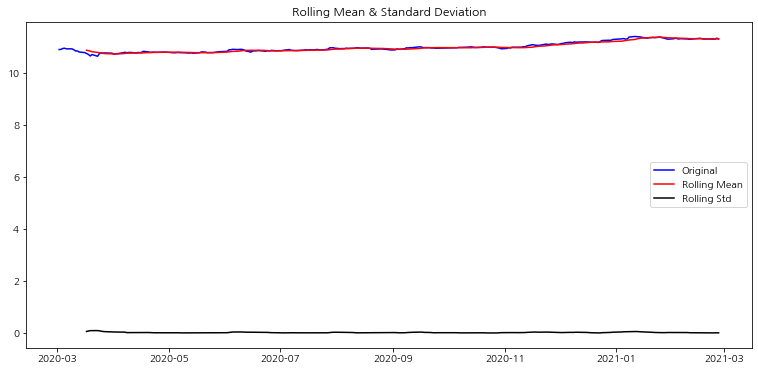

Results of Dickey-Fuller Test:
Test Statistic                  -0.138318
p-value                          0.945486
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


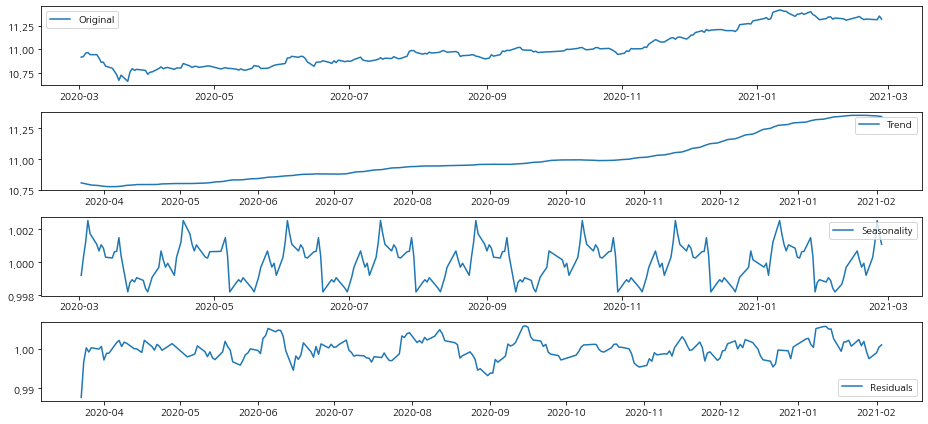

In [50]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [51]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.577129e+00
p-value                        7.675481e-09
#Lags Used                     0.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

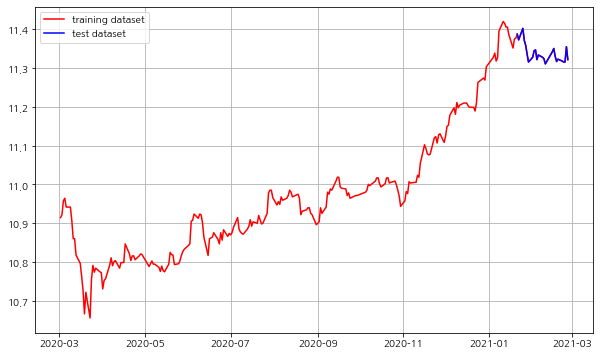

In [52]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


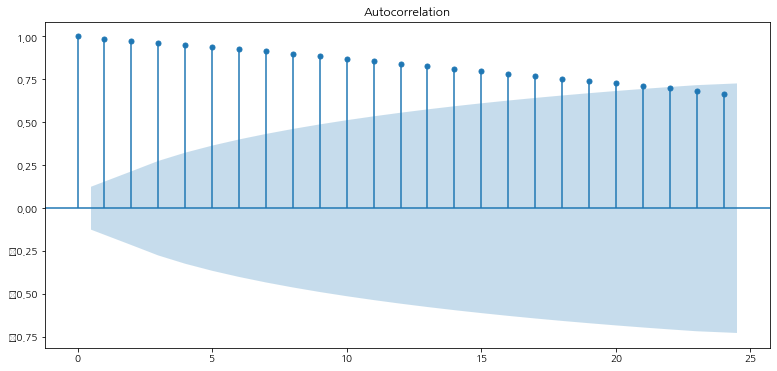

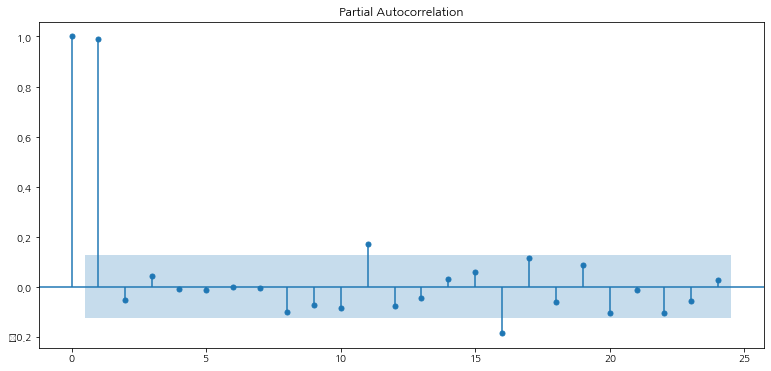

In [53]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.605903e+01
p-value                        5.665557e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


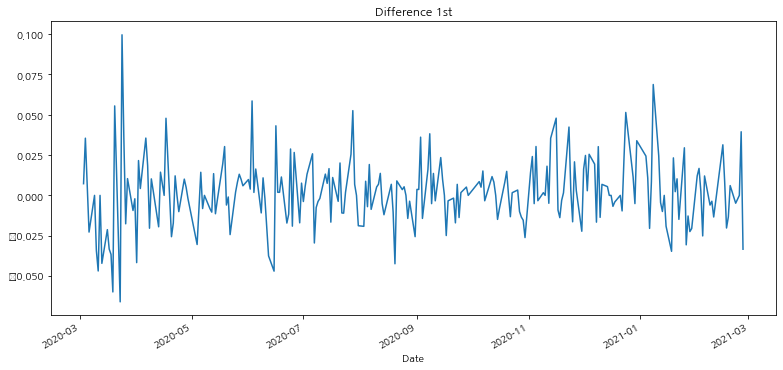

In [54]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -6.958644e+00
p-value                        9.287130e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+00
Critical Value (10%)          -2.573571e+00
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


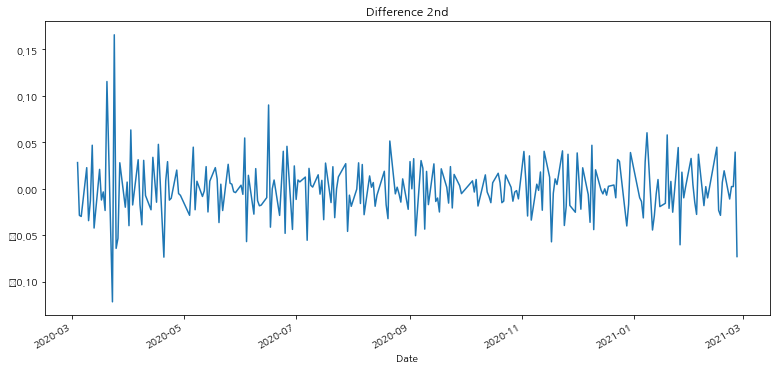

In [55]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [56]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  220
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 532.334
Method:                       css-mle   S.D. of innovations              0.022
Date:                Mon, 01 Mar 2021   AIC                          -1058.667
Time:                        01:49:26   BIC                          -1048.486
Sample:                             1   HQIC                         -1054.556
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0021      0.001      1.474      0.141      -0.001       0.005
ar.L1.D.Close    -0.0210      0.067     -0.312      0.755      -0.153       0.111
                                    Root

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

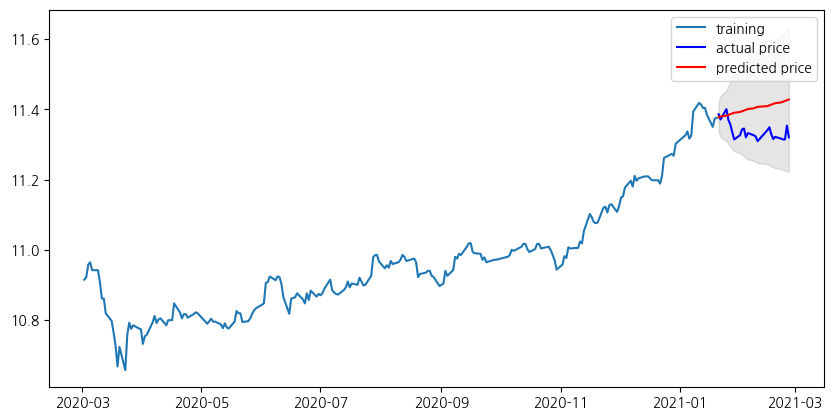

In [57]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  41618901.981692016
MAE:  5862.097295866904
RMSE:  6451.271346152789
MAPE: 7.06%


# STEP 7 : 다른 주식 종목 예측해 보기

## 주식종목
```
HMM Co.,Ltd    : 한국의 해운업체         011200.KS.csv 
TSLA           : 자동차 제조 및 판매업    TSLA.csv
 Alphabet Inc.  : 구글 모회사           GOOG.csv
```
```
야후에서 다운로드후 파일 이동
$ mv ~/Downloads/011200.KS.csv ~/aiffel/stock_prediction/data
$ mv ~/Downloads/TSLA.csv ~/aiffel/stock_prediction/data
$ mv ~/Downloads/GOOG.csv ~/aiffel/stock_prediction/data
$ mv ~/Downloads/011200.KS\(1\).csv ~/aiffel/stock_prediction/data   상장시작부터 현재까지

```

https://finance.yahoo.com/quote/TSLA/history?p=TSLA
https://finance.yahoo.com/quote/011200.KS?ltr=1

# STEP 1 : 시계열 데이터 준비

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset01_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/011200.KS.csv'
dataset02_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'


df01 = pd.read_csv(dataset01_filepath, index_col='Date', parse_dates=True)
ts01 = df01['Close']

df02 = pd.read_csv(dataset02_filepath, index_col='Date', parse_dates=True)
ts02 = df02['Close']

In [9]:
# HMM
ts01.head()

Date
2020-03-03    3405.0
2020-03-04    3525.0
2020-03-05    3730.0
2020-03-06    3670.0
2020-03-09    3670.0
Name: Close, dtype: float64

In [10]:
# 테슬라
ts02.head()

Date
2020-03-03    149.102005
2020-03-04    149.899994
2020-03-05    144.908005
2020-03-06    140.695999
2020-03-09    121.599998
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

## 결측치 처리

In [11]:
# 결측치 처리
ts01=ts01.interpolate(method='time')
ts02=ts02.interpolate(method='time')

In [12]:
# HMM
ts01[ts01.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [13]:
#테슬라
ts02[ts02.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

## 로그 변환 

In [14]:
# 로그 변환 시도 
ts01_log = np.log(ts01)
ts02_log = np.log(ts02)

# STEP 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

## statsmodels 패키지와 adfuller 메소드
statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지입니다. 이번 노드에서는 statsmodels 패키지의 기능을 자주 활용하게 될 것입니다. 아래는 statsmodels 패키지에서 제공하는 adfuller 메소드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드입니다.

아래 코드를 수행하기 위해 먼저 다음과 같이 statsmodels 패키지를 설치합니다.

$ pip install statsmodels

In [18]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [19]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


## HMM에 대한 시계열 안정성 분석

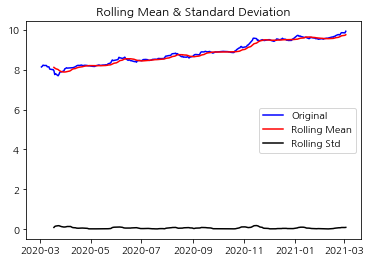

Results of Dickey-Fuller Test:
Test Statistic                   0.018680
p-value                          0.960050
#Lags Used                       3.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


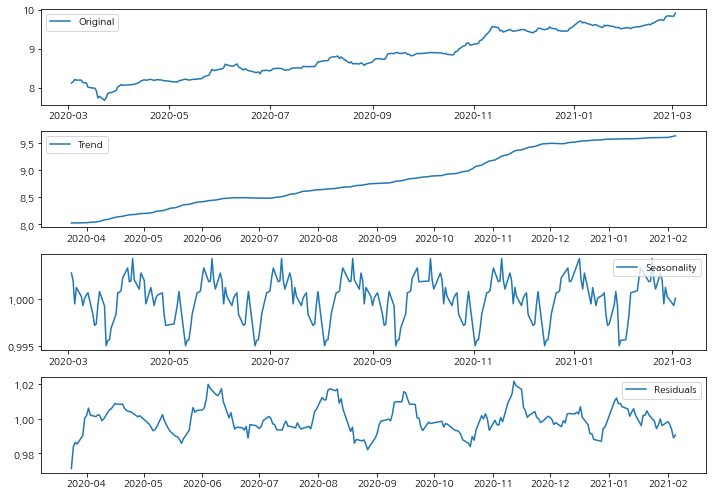

In [26]:
# 정성적 그래프 분석
plot_rolling_statistics(ts01_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts01_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition01 = seasonal_decompose(ts01_log, model='multiplicative', period = 30) 

trend01 = decomposition01.trend
seasonal01 = decomposition01.seasonal
residual01 = decomposition01.resid

plt.figure(figsize=(10,7))
plt.subplot(411)
plt.plot(ts01_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend01, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal01,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual01, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## 테슬라에 대한 시계열 안정성 분석¶

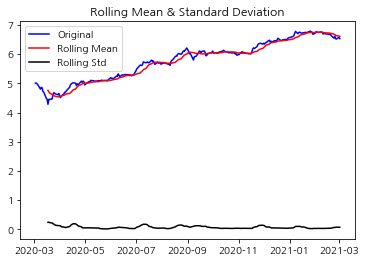

Results of Dickey-Fuller Test:
Test Statistic                  -0.677590
p-value                          0.852469
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


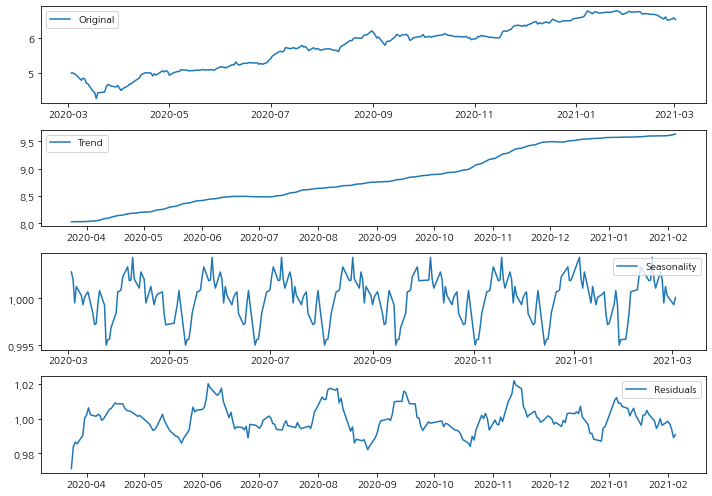

In [27]:
# 정성적 그래프 분석
plot_rolling_statistics(ts02_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts02_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition02 = seasonal_decompose(ts02_log, model='multiplicative', period = 30) 

trend02 = decomposition01.trend
seasonal02 = decomposition01.seasonal
residual02 = decomposition01.resid

plt.figure(figsize=(10,7))
plt.subplot(411)
plt.plot(ts02_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend02, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal02,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual02, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# STEP 4 : 학습, 테스트 데이터셋 생성
학습, 테스트 데이터셋 분리

## HMM 테스트 데이터셋 생성

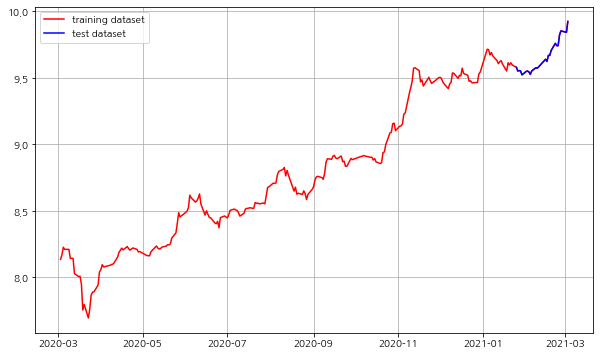

In [30]:
train01_data, test01_data = ts01_log[:int(len(ts01_log)*0.9)], ts01_log[int(len(ts01_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts01_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test01_data, c='b', label='test dataset')
plt.legend()

## 테슬라 테스트 데이터셋 생성

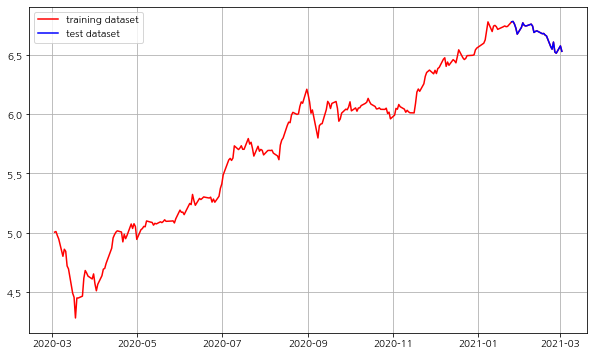

In [31]:
train02_data, test02_data = ts02_log[:int(len(ts02_log)*0.9)], ts02_log[int(len(ts02_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts02_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test02_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기

## HMM 적정 ARIMA 모수 찾기

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


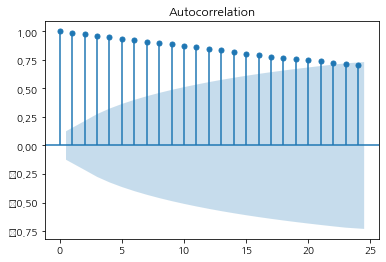

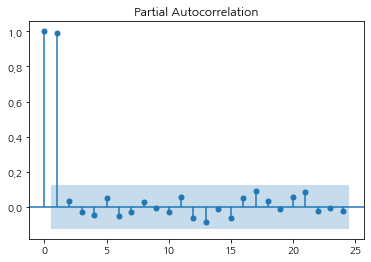

In [33]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts01_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts01_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -6.878667e+00
p-value                        1.452335e-09
#Lags Used                     2.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


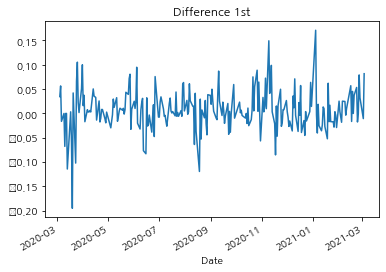

In [35]:
# 1차 차분 구하기
diff01_1 = ts01_log.diff(periods=1).iloc[1:]
diff01_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff01_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.357547e+00
p-value                        2.881801e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


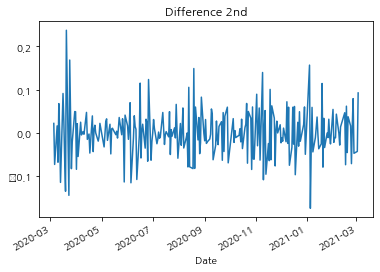

In [36]:
# 혹시 필요한 경우 2차 차분 구하기
diff01_2 = diff01_1.diff(periods=1).iloc[1:]
diff01_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff01_2)

## 테슬라 적정 ARIMA 모수 찾기

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


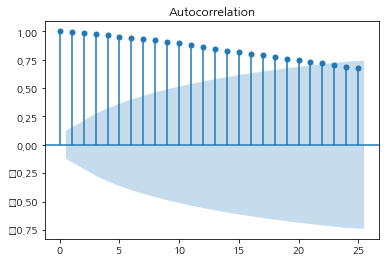

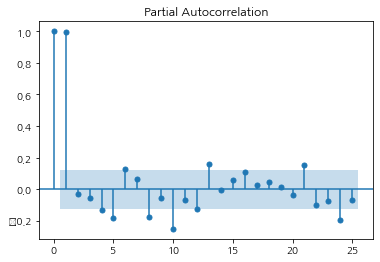

In [34]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts02_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts02_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.612415e+01
p-value                        4.862162e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


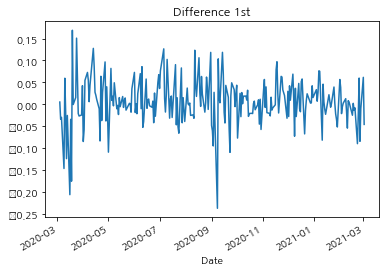

In [37]:
# 1차 차분 구하기
diff02_1 = ts02_log.diff(periods=1).iloc[1:]
diff02_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff02_1)

Results of Dickey-Fuller Test:
Test Statistic                -6.735889e+00
p-value                        3.208440e-09
#Lags Used                     1.200000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


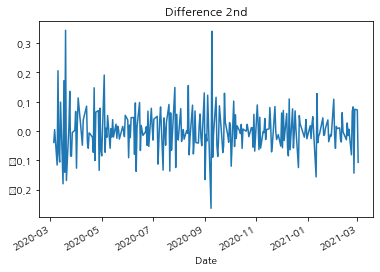

In [38]:
# 혹시 필요한 경우 2차 차분 구하기
diff02_2 = diff02_1.diff(periods=1).iloc[1:]
diff02_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff02_2)

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

## HMM 훈련과 테스트

In [40]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model01 = ARIMA(train01_data, order=(1, 1, 0))  
fitted01_m = model01.fit(disp=-1)  
print(fitted01_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 390.079
Method:                       css-mle   S.D. of innovations              0.041
Date:                Wed, 03 Mar 2021   AIC                           -774.158
Time:                        20:01:59   BIC                           -763.963
Sample:                             1   HQIC                          -770.041
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0066      0.003      2.135      0.033       0.001       0.013
ar.L1.D.Close     0.1020      0.067      1.526      0.127      -0.029       0.233
                                    Root

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


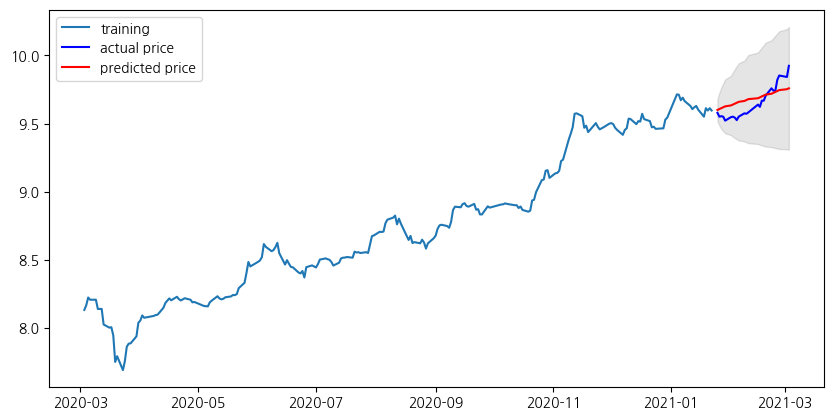

In [42]:
# Forecast : 결과가 fc에 담깁니다. 
fc01, se01, conf01 = fitted01_m.forecast(len(test01_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc01_series = pd.Series(fc01, index=test01_data.index)   # 예측결과
lower01_series = pd.Series(conf01[:, 0], index=test01_data.index)  # 예측결과의 하한 바운드
upper01_series = pd.Series(conf01[:, 1], index=test01_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train01_data, label='training')
plt.plot(test01_data, c='b', label='actual price')
plt.plot(fc01_series, c='r',label='predicted price')
plt.fill_between(lower01_series.index, lower01_series, upper01_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse01 = mean_squared_error(np.exp(test01_data), np.exp(fc01))
print('MSE: ', mse01)

mae01 = mean_absolute_error(np.exp(test01_data), np.exp(fc01))
print('MAE: ', mae01)

rmse01 = math.sqrt(mean_squared_error(np.exp(test01_data), np.exp(fc01)))
print('RMSE: ', rmse01)

mape01 = np.mean(np.abs(np.exp(fc01) - np.exp(test01_data))/np.abs(np.exp(test01_data)))
print('MAPE: {:.2f}%'.format(mape01*100))

MSE:  1746899.1473582855
MAE:  1144.7452947901568
RMSE:  1321.7031237605083
MAPE: 7.38%


## 테슬라 훈련과 테스트

In [47]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model02 = ARIMA(train02_data, order=(1, 1, 0))  
fitted02_m = model02.fit(disp=-1)  
print(fitted02_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 337.297
Method:                       css-mle   S.D. of innovations              0.054
Date:                Wed, 03 Mar 2021   AIC                           -668.594
Time:                        20:07:10   BIC                           -658.345
Sample:                             1   HQIC                          -664.457
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0077      0.004      2.197      0.028       0.001       0.015
ar.L1.D.Close    -0.0253      0.066     -0.381      0.703      -0.156       0.105
                                    Root

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

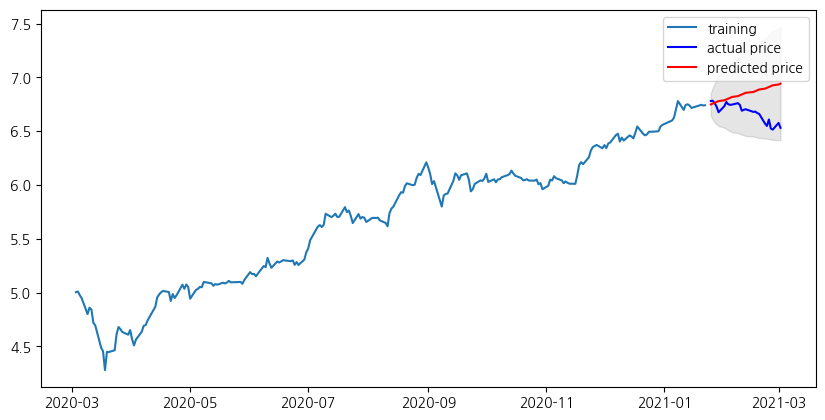

In [48]:
# Forecast : 결과가 fc에 담깁니다. 
fc02, se02, conf02 = fitted02_m.forecast(len(test02_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc02_series = pd.Series(fc02, index=test02_data.index)   # 예측결과
lower02_series = pd.Series(conf02[:, 0], index=test02_data.index)  # 예측결과의 하한 바운드
upper02_series = pd.Series(conf02[:, 1], index=test02_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train02_data, label='training')
plt.plot(test02_data, c='b', label='actual price')
plt.plot(fc02_series, c='r',label='predicted price')
plt.fill_between(lower02_series.index, lower02_series, upper02_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse02 = mean_squared_error(np.exp(test02_data), np.exp(fc02))
print('MSE: ', mse02)

mae02 = mean_absolute_error(np.exp(test02_data), np.exp(fc02))
print('MAE: ', mae02)

rmse02 = math.sqrt(mean_squared_error(np.exp(test02_data), np.exp(fc02)))
print('RMSE: ', rmse02)

mape02 = np.mean(np.abs(np.exp(fc02) - np.exp(test02_data))/np.abs(np.exp(test02_data)))
print('MAPE: {:.2f}%'.format(mape02*100))

MSE:  34132.56819502281
MAE:  147.0422205775697
RMSE:  184.75001541278098
MAPE: 19.74%


# Alphabet Inc. (GOOG) 예측하기(상장이후부터)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset03_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/GOOG.csv'


df03 = pd.read_csv(dataset03_filepath, index_col='Date', parse_dates=True)
ts03 = df03['Close']

# HMM
ts03.head()

Date
2004-08-19    49.982655
2004-08-20    53.952770
2004-08-23    54.495735
2004-08-24    52.239197
2004-08-25    52.802086
Name: Close, dtype: float64

### 결측치 처리

In [7]:
# 결측치 처리
ts03=ts03.interpolate(method='time')

ts03[ts03.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

### 로그 변환

In [8]:
# 로그 변환 시도 
ts03_log = np.log(ts03)

### 시계열 안정성 분석

window을 365로 설정

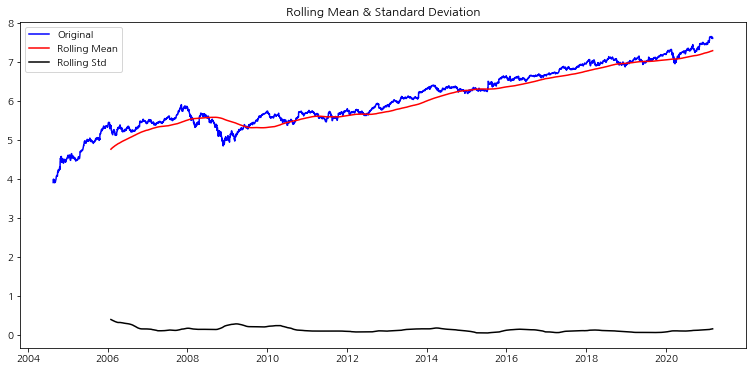

Results of Dickey-Fuller Test:
Test Statistic                   -1.895851
p-value                           0.334016
#Lags Used                        7.000000
Number of Observations Used    4155.000000
Critical Value (1%)              -3.431925
Critical Value (5%)              -2.862236
Critical Value (10%)             -2.567140
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


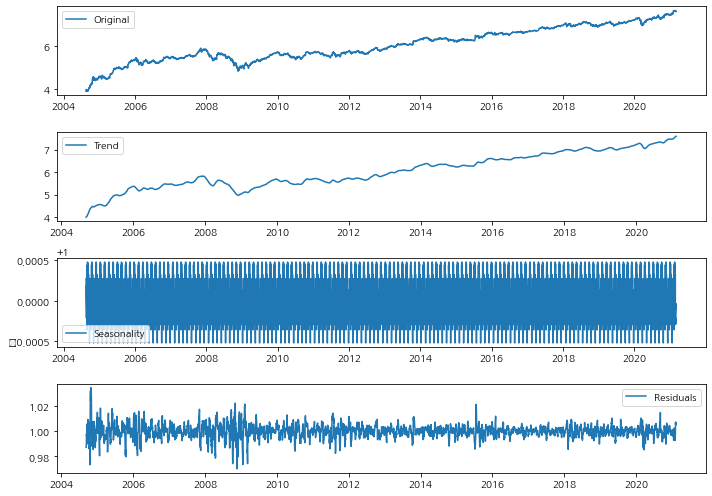

In [34]:
# 정성적 그래프 분석
plot_rolling_statistics(ts03_log, window=365
                       )

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts03_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition03 = seasonal_decompose(ts03_log, model='multiplicative', period = 30) 

trend03 = decomposition03.trend
seasonal03 = decomposition03.seasonal
residual03 = decomposition03.resid

plt.figure(figsize=(10,7))
plt.subplot(411)
plt.plot(ts03_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend03, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal03,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual03, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 학습, 테스트 데이터셋 생성

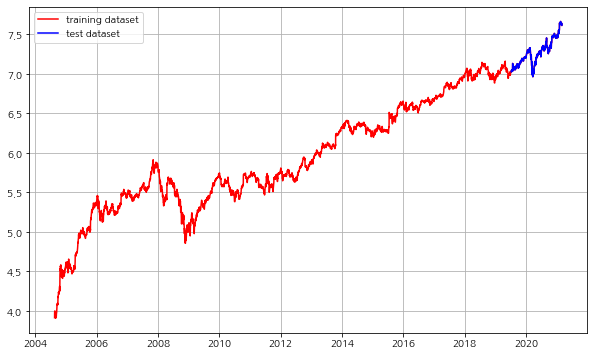

In [36]:
train03_data, test03_data = ts03_log[:int(len(ts03_log)*0.9)], ts03_log[int(len(ts03_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts03_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test03_data, c='b', label='test dataset')
plt.legend()

### 적정 ARIMA 모수 찾기

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


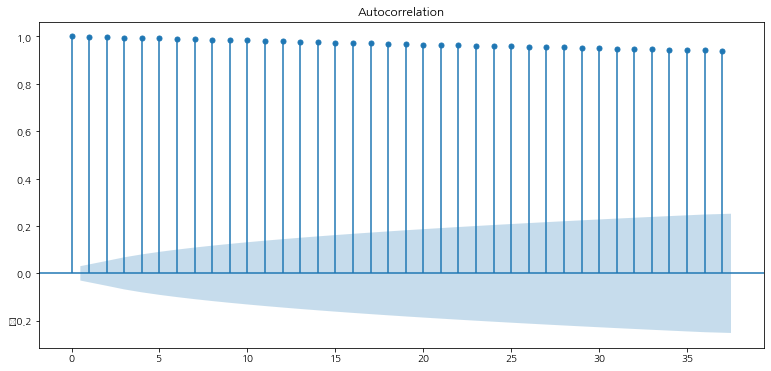

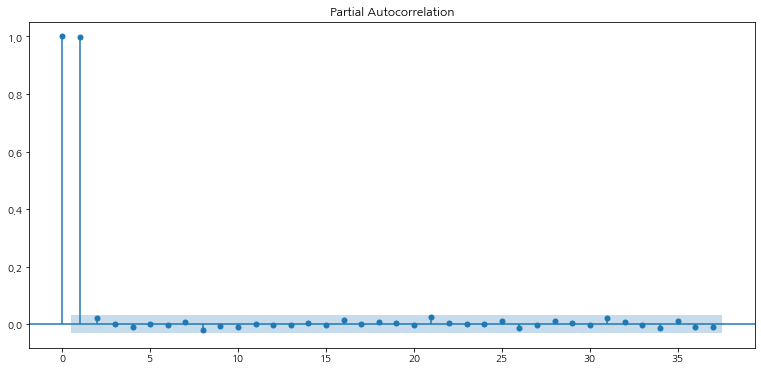

In [37]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts03_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts03_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -24.620477
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    4155.000000
Critical Value (1%)              -3.431925
Critical Value (5%)              -2.862236
Critical Value (10%)             -2.567140
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


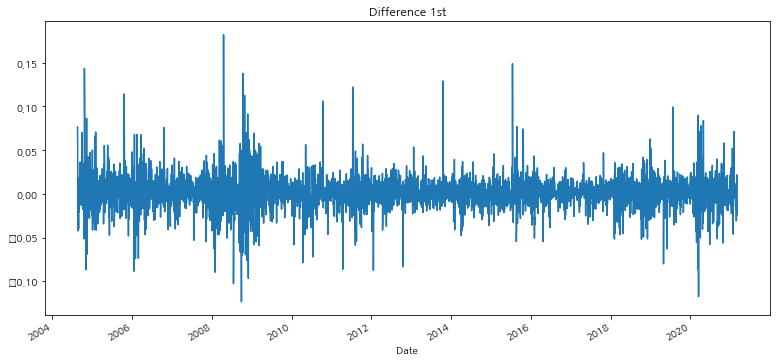

In [38]:
# 1차 차분 구하기
diff03_1 = ts03_log.diff(periods=1).iloc[1:]
diff03_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff03_1)

Results of Dickey-Fuller Test:
Test Statistic                  -20.532330
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    4129.000000
Critical Value (1%)              -3.431935
Critical Value (5%)              -2.862240
Critical Value (10%)             -2.567143
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


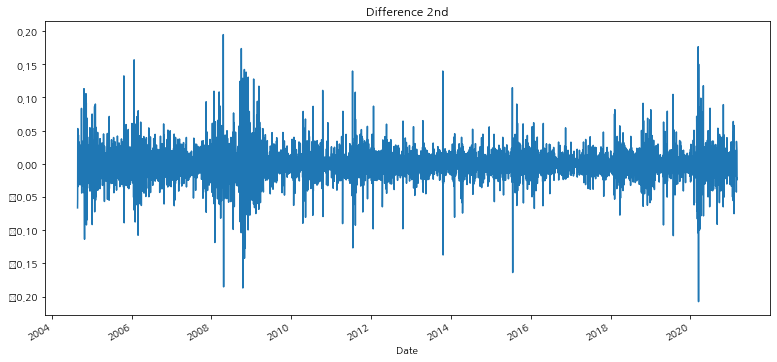

In [39]:
# 혹시 필요한 경우 2차 차분 구하기
diff03_2 = diff03_1.diff(periods=1).iloc[1:]
diff03_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff03_2)

### ARIMA 모델 훈련과 테스트

In [40]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model03 = ARIMA(train03_data, order=(1, 1, 0))  
fitted03_m = model03.fit(disp=-1)  
print(fitted03_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3745
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9551.347
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 04 Mar 2021   AIC                         -19096.693
Time:                        12:41:50   BIC                         -19078.009
Sample:                             1   HQIC                        -19090.048
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.659      0.008       0.000       0.001
ar.L1.D.Close     0.0107      0.016      0.655      0.512      -0.021       0.043
                                    Root

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

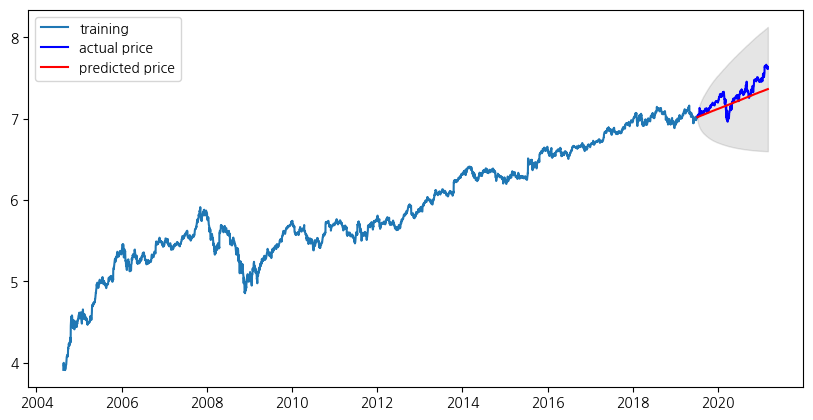

In [41]:
# Forecast : 결과가 fc에 담깁니다. 
fc03, se03, conf03 = fitted03_m.forecast(len(test03_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc03_series = pd.Series(fc03, index=test03_data.index)   # 예측결과
lower03_series = pd.Series(conf03[:, 0], index=test03_data.index)  # 예측결과의 하한 바운드
upper03_series = pd.Series(conf03[:, 1], index=test03_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train03_data, label='training')
plt.plot(test03_data, c='b', label='actual price')
plt.plot(fc03_series, c='r',label='predicted price')
plt.fill_between(lower03_series.index, lower03_series, upper03_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse03 = mean_squared_error(np.exp(test03_data), np.exp(fc03))
print('MSE: ', mse03)

mae03 = mean_absolute_error(np.exp(test03_data), np.exp(fc03))
print('MAE: ', mae03)

rmse03 = math.sqrt(mean_squared_error(np.exp(test03_data), np.exp(fc03)))
print('RMSE: ', rmse03)

mape03 = np.mean(np.abs(np.exp(fc03) - np.exp(test03_data))/np.abs(np.exp(test03_data)))
print('MAPE: {:.2f}%'.format(mape03*100))

MSE:  34945.00251539792
MAE:  143.2144549482689
RMSE:  186.9358245906812
MAPE: 9.10%


# HMM 예측하기(상징이후부터)

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset03_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/011200.KS(1).csv'

df03 = pd.read_csv(dataset03_filepath, index_col='Date', parse_dates=True)
ts03 = df03['Close']

# HMM
ts03.head()

Date
2000-01-04    41011.183594
2000-01-05    39273.867188
2000-01-06    37168.027344
2000-01-07    37694.488281
2000-01-10    37905.070313
Name: Close, dtype: float64

### 결측치 처리

In [46]:
# 결측치 처리
ts03=ts03.interpolate(method='time')

ts03[ts03.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

### 로그 변환

In [47]:
# 로그 변환 시도 
ts03_log = np.log(ts03)

### 시계열 안정성 분석

window을 365로 설정

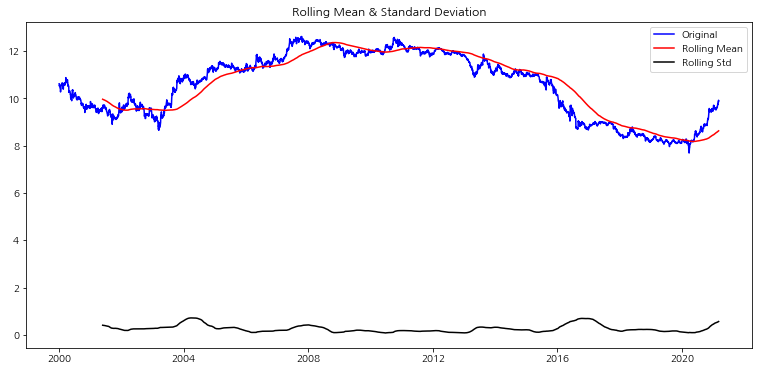

Results of Dickey-Fuller Test:
Test Statistic                   -0.970015
p-value                           0.764043
#Lags Used                        6.000000
Number of Observations Used    5314.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


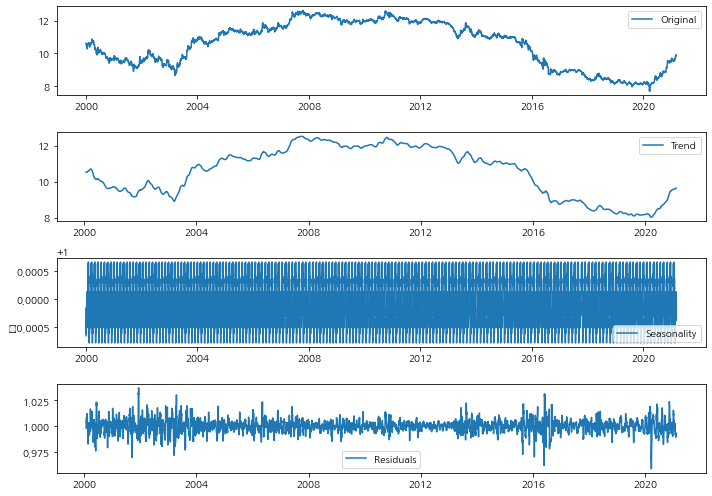

In [48]:
# 정성적 그래프 분석
plot_rolling_statistics(ts03_log, window=365
                       )

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts03_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition03 = seasonal_decompose(ts03_log, model='multiplicative', period = 30) 

trend03 = decomposition03.trend
seasonal03 = decomposition03.seasonal
residual03 = decomposition03.resid

plt.figure(figsize=(10,7))
plt.subplot(411)
plt.plot(ts03_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend03, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal03,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual03, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 학습, 테스트 데이터셋 생성

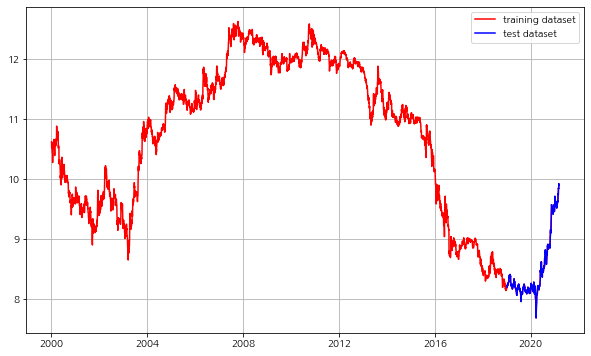

In [49]:
train03_data, test03_data = ts03_log[:int(len(ts03_log)*0.9)], ts03_log[int(len(ts03_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts03_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test03_data, c='b', label='test dataset')
plt.legend()

### 적정 ARIMA 모수 찾기

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


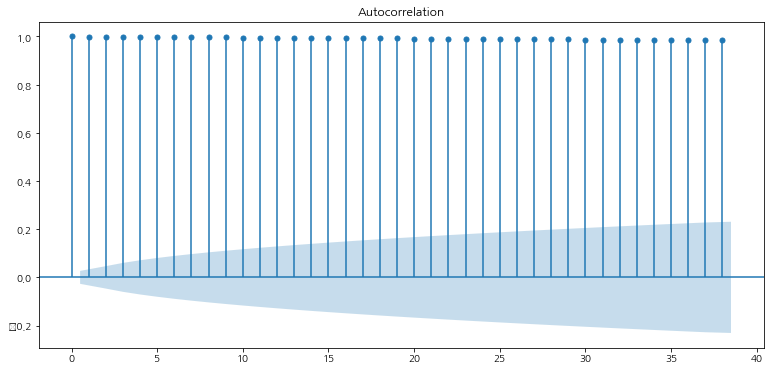

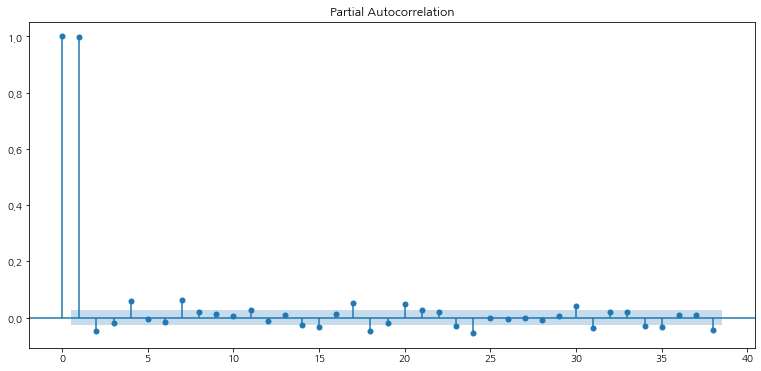

In [50]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts03_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts03_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -31.095553
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    5314.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


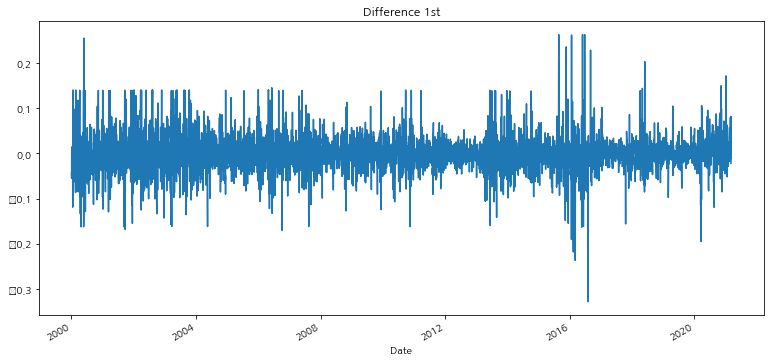

In [51]:
# 1차 차분 구하기
diff03_1 = ts03_log.diff(periods=1).iloc[1:]
diff03_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff03_1)

Results of Dickey-Fuller Test:
Test Statistic                  -22.114657
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5285.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


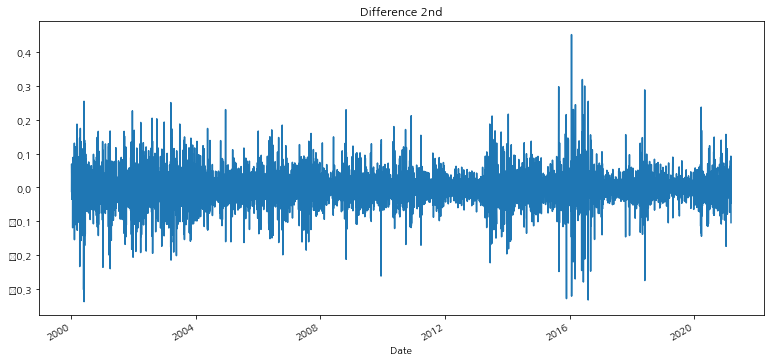

In [52]:
# 혹시 필요한 경우 2차 차분 구하기
diff03_2 = diff03_1.diff(periods=1).iloc[1:]
diff03_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff03_2)

### ARIMA 모델 훈련과 테스트

In [53]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model03 = ARIMA(train03_data, order=(1, 1, 0))  
fitted03_m = model03.fit(disp=-1)  
print(fitted03_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4787
Model:                 ARIMA(1, 1, 0)   Log Likelihood                8565.862
Method:                       css-mle   S.D. of innovations              0.040
Date:                Thu, 04 Mar 2021   AIC                         -17125.724
Time:                        12:55:47   BIC                         -17106.303
Sample:                             1   HQIC                        -17118.903
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0005      0.001     -0.842      0.400      -0.002       0.001
ar.L1.D.Close     0.0247      0.014      1.711      0.087      -0.004       0.053
                                    Root

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

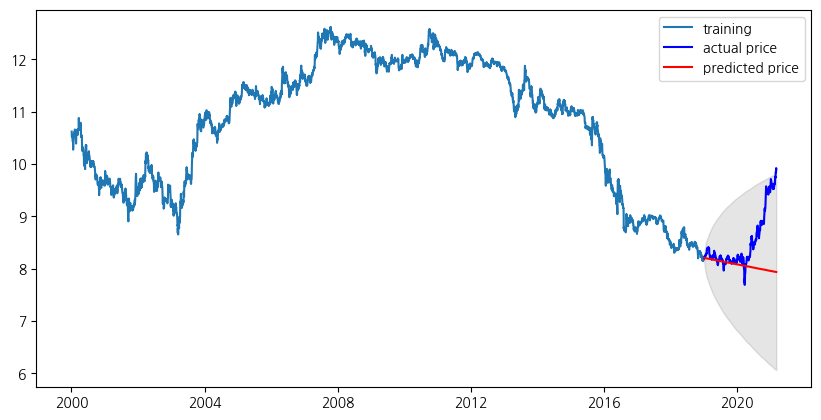

In [54]:
# Forecast : 결과가 fc에 담깁니다. 
fc03, se03, conf03 = fitted03_m.forecast(len(test03_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc03_series = pd.Series(fc03, index=test03_data.index)   # 예측결과
lower03_series = pd.Series(conf03[:, 0], index=test03_data.index)  # 예측결과의 하한 바운드
upper03_series = pd.Series(conf03[:, 1], index=test03_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train03_data, label='training')
plt.plot(test03_data, c='b', label='actual price')
plt.plot(fc03_series, c='r',label='predicted price')
plt.fill_between(lower03_series.index, lower03_series, upper03_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse03 = mean_squared_error(np.exp(test03_data), np.exp(fc03))
print('MSE: ', mse03)

mae03 = mean_absolute_error(np.exp(test03_data), np.exp(fc03))
print('MAE: ', mae03)

rmse03 = math.sqrt(mean_squared_error(np.exp(test03_data), np.exp(fc03)))
print('RMSE: ', rmse03)

mape03 = np.mean(np.abs(np.exp(fc03) - np.exp(test03_data))/np.abs(np.exp(test03_data)))
print('MAPE: {:.2f}%'.format(mape03*100))

MSE:  22894729.4161725
MAE:  2565.627863593983
RMSE:  4784.843719096007
MAPE: 27.29%


# 끝

![삼성20 03-2102](https://user-images.githubusercontent.com/59362727/109913010-89c02b80-7cf0-11eb-8274-3dc5a5af9882.png)
![테슬라20 03-21 02](https://user-images.githubusercontent.com/59362727/109913011-8a58c200-7cf0-11eb-8e8b-c751159a1961.png)
![알파벳full](https://user-images.githubusercontent.com/59362727/109913013-8af15880-7cf0-11eb-8cfd-2cebf3a57e42.png)
![HMM-20 03-2102](https://user-images.githubusercontent.com/59362727/109913015-8af15880-7cf0-11eb-998e-9c80ac02f9af.png)
![HNN_full](https://user-images.githubusercontent.com/59362727/109913016-8b89ef00-7cf0-11eb-9a54-27c80fedbc81.png)


# 프로젝트 후(위 그림참조)
삼성 1년, HMM 1년, 구글(상장 이후부터) 일 경우 어느 정도 예측을 했다. (MAPE가 10보다 작다) 반대로
HMM(상징 이후부터), 테슬라 1년 치인 경우는 예측이 빗나갔다. (MAPE가 상당히 높다) 이런 결과로 시계열 데이터 분석으로 주식을 판단하는 것은 어려운 것 같다. 노드 첫 부분에 말한 것처럼 시계열 데이터로 분석을 하기 위해서는 데이터가 안정적(stationary)이 깔려야 된다고 하였다. 특히 주식에서는 예측하지 못하는 여러 가지의 변수가 있다. 그중에서도 최근 코로나 19로 인하여 시계열 데이터분석에 대한 엄청난 변수가 있었기에 더욱 판단하기 어렵다고 생각된다. 그리고 참고로 코로나가 시작된 작년 3월에 모든 분야가 최저점을 시간이 지남에 따라 상승세를 찍고 있다. 이런 점을 본다면 지금으로부터 1년 치에 대한 MAPE은 비교적 낮을 거라는 생각이 든다. 글쓴이 같은 경우는 MAPE을 낮추기 위한 ARIMA의 변수(p,d,q) 설정보다는 시계열의 전체적인 개념을 이해하는 방향으로 노드를 진행하였다.(어렵다...)




###

# 개념

### 시계열이란
- 시간 순서대로 발생한 데이터의 수열(즉 시간순서에 따라 변하는 값들,규칙이 있을수도있고 없을수도 있고)
- 시계열 자료를 분석함에 있어, 보통 시계열이 안정적(stationary)이라는 가정이 깔려있다.


### 시계열로 미래를 예측하기위한 조건 2가지
- 과거의 데이터에 일정한 패턴이 발견된다.
- 과거의 패턴은 미래에도 동일하게 반복될 것이다    
즉 안정적(Stationary) 데이터에 대해서만 미래 예측이 가능하다.       
(안정적이라다는 의미는 시계열 데이터의 통계적 특성이 변하지 않는다.)    


### 시계열 데이터분석은 완벽하지 않다.
시계열 데이터 분석은 완벽한 미래 예측을 보장하지는 않는다. 어떤 예측하지 못한 외부적 변수에 의해 시계열 데이터 분석의 전제가 되는 안정성(stationarity)이 훼손될 여지가 있기 때문이다.   
그럼에도 시계열 데이터분석은 시간적 변화를 표현하는데 휼륭한 성능을 보인다.



### 시계열에서 안정적(Stationary)이다라는 의미
- 데이터의 통계적 특성이 변하지 않는다.
- 시계열의 평균과 분산이 시간의 흐름에 따라 체계적으로 변화하지 않는다는 것   
예로 매일변화하는 날씨같은경우 연단위로 볼때 기후 변화의 일정한 패턴이 유지될 경우,기후변화에 대한 프로세스를 만들어 내일의 날씨를 어느정도 오차범위 내에 예측할수 있을것이다.

### stationary time series(안정적 시계열)
(안정적 시계열 = 정상시계열 = 정상성 시계열)   
- 통계적인 특성이 변하지 않는 시계열을 안정적 시계열이라고 한다.
- 안정적 시계열의 시간의 추이와 관계 없이 일정한 통계적 특성은 3가지    
평균, 분산,자기공분산(autocovariance)   

﻿

### 공분산(Covariance)
- 확률변수들이 어떻게 퍼져있는지를 나타내는 것(x 편차와 Y의 편차를 곱하것의 평균)
- 분산은 하나의 변수(x)에 대한 펴져있는것을 나타낸것이고, 공분산경우는 x,y 두개 이상의 변수에 대한 분산을 구하는것

### 자기공분산(autocovariance)
자기자신을 공분산한다. 완전히 자기 자신을 공분산하는것이 아니라 h만큼 이동한 자기자신과 공분산다.즉 x, x+h의 분산을 구한다.
```
x   => 현재 자신   
x+h => 현재 자신에서 h만큼 이동한 자신
```
### 상관계수(Correlation)
- 확률 변수의 절대적 크기에 영향을 받지 않도록 단위화 시켜주는 역할함
- 공분산의 문제점을 해결하는 방법이 상관계수
- x와 y의 확률 변수가 있을때 x와 y의 변수 단위가 엄첨나게 차이가 있다면 공분산의 값은 의미가 없을것이다.
```
즉 x,y의 변수 단위에 영향을 크게 받는다
[x인 경우 만점=100, y인 경우 만점=10] 이라면 두변수간의 상관성을 직접 대표하지 못한다. 그래서 우리는 두 변수간의 상관성을 -1 ~ 1로 설정한다. 
```
https://destrudo.tistory.com/15   
https://m.blog.naver.com/PostView.nhn?blogId=sw4r&logNo=221030974616&proxyReferer=https:%2F%2Fwww.google.com%2F

### 프로젝트에서 시계열 데이터 처리 순서 
1. DataFrame에서 Date컬럼을 index로 삼는다.
2. 결측치 제거 혹은 보간 작업
 - 1)결측치가 있는 데이터를 모두 삭제(drop)하거나, 
 - 2)결측치 양옆의 값들을 이용해서 적절히 보간(interpolate) 대입해 주는 방법 사용
   판다스 보관처리 메소드 .https://rfriend.tistory.com/264
3. 원본시계열, 이동평균, 이동표준편차 시각화
4. stationary여부 체크
5. stationary한 데이터로 만들기
- 로그함수 변환
- Moving average 제거 - 추세(Trend) 상쇄하기 
- 차분(Differencing) - 계절성(Seasonality) 상쇄하기    
6. 5번단계 필요없이 ARIMA모델 활용(ARIMA모델안 알아서 데이터를 처리한다.)

### Augmented Dickey-Fuller Test(ADF Test)란 
- 시계열 데이터의 안정성을 테스트하기 사용된다.
- 이 테스트는 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후, 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다는 내용입니다.
- 즉 p-value(유의 확률)의 값이 낮을때 채택한다.

### p-value(유의확률)이란 어떤 의미인가요?
- 귀무가설이 참임에도 이를 기각할 확률()
- 귀무가설을 지지하는 정도(낮을수록 기각한다.) 

### 귀무가설
- 가설검정의 대상이 되는 가설. 귀무가설은 일반적으로 기각될 것이 예상되어 세워진 가설이고 검증하려는 가설은 귀무가설에 대해서 대립 가설 anti hypothesis로 불린다. 

### 대립가설
- 귀무가설의 반대 가설

귀무가설: 암과 흡연은 관련이 없다.

대립가설: 암과 흡연은 관련이 있다.

귀무가설은 채택될수 없고, 기각 여부만 결정된다.

귀무가설, 대립가설, 유의확률 개념참조  
https://blog.naver.com/navehag
https://m.blog.naver.com/baedical/10109291879
https://m.blog.naver.com/moses3650/221217938069

### statsmodels 패키지와 adfuller 메소드
- 현재 프로젝트에서 stationnary여부 체크할때 사용된다.
- statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지
- statsmodels 패키지에서 제공하는 adfuller 메소드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행한다.

### staionary(안정성) 하기 만드는법
- 1)정성적인 분석을 통해 보다 안정적(starionary)인 특성을 가지도록 기존의 시계열 데이터를 가공/변형한다.

- 2)시계열 분해(Time series decomposition)라는 기법을 적용
    
    
- 안정성이다라면  p-value(유의 확률)이 낮아진다. 즉 귀무가설 값들이 많이 기각되었다.

- 로그화 변환

### 이동평균 (MA, Moving Average)= 롤링산술평균(Rolling Mean)
- 이동 평균은 moving average, rolling average, rolling mean 또는 running average라고 한다.
- 지정된 간격 안에서 노드 평균을 계산하는 데 사용합니다. 간격 크기가 3으로 설정된 경우 현재 노드와 앞의 두 노드를 사용하여 평균이 계산됩니다. 이동 평균을 사용하는 목적은 일반적으로 단기 변동을 평준화하고 장기 동향을 파악하는 것입니다.
https://docs.tibco.com/pub/spotfire_web_player/6.0.0-november-2013/ko-KR/WebHelp/GUID-5A18B4F1-8465-4200-881A-8721BF1A48B1.html


- 이동평균은 시계열 데이터 내의 잡음(noise)을 제거하는 데이터 전처리, 혹은 계절성이 존재하는 시계열 데이터에서 계절성 부분을 빼고 장기 추세 요인(trend factor)나 중기 순환/주기 요인(cycle factor)를 보려고 할 때 많이 사용합니다. 시계열 데이터 예측(forecasting)에도 사용한다.    
https://rfriend.tistory.com/502 


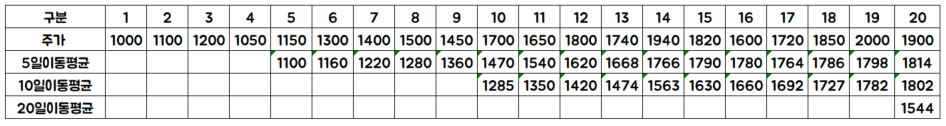

https://paultrader.tistory.com/24

### rolling(window=12).mean() 의미는?
- 11번까지는 NAN나옴 12번째는 1 ~ 12번째 평균, 13번째는 2 ~ 13번째 평균, 14번째는 3 ~ 14번째 평균 이렇게 끝까지 평균을 내는것을 이동평균이라고 한다.
- moving average를 고려할 때는 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요하다는 것을 기억해 둡시다

### 그림의 의미는 무엇인가?
```
파란색은 trend(추세)
빨간색은 MA, Moving Average(이동평균)
```

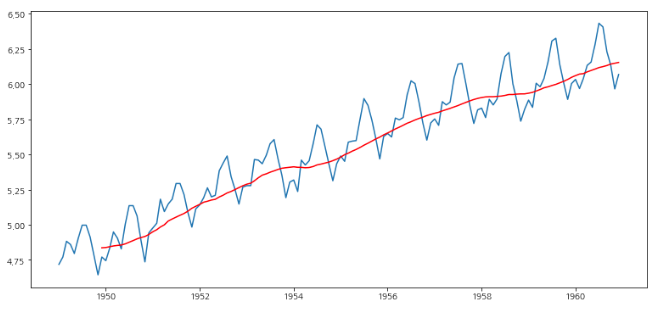

ts_log_moving_avg = ts_log - moving_avg # 변화량 제거    
ts_log_moving_avg = 트렌드 - 빨강색(MA)    
위와 같은 방식으로 변화량 제거한다고 한다.
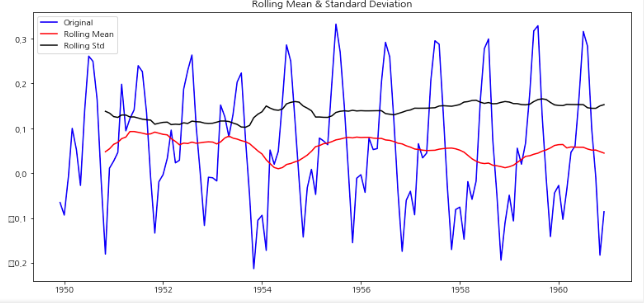

### 주기적 패턴- 계절성(Seasonality)
- Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소입니다.
- Moving Average 제거로 상쇄되지 않는 요소

### 차분(Differencing)
- 예측에 방해 되는 주기적 패턴의 계절성을 제거해준다.
- 현재 스텝 값 - 직전 스텝 값

- 직전이 파란색, 현재가 녹색
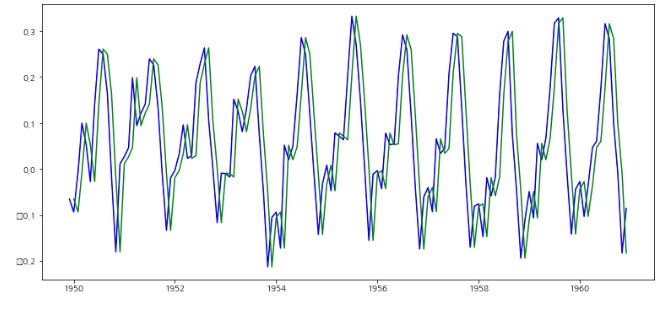

### 시계열 분해(Time series decomposition)
Trend+Seasonality+Residual=Original 식에서  Residual뽑아 내어 시계열 데이터를 예측한다.?

### ARIMA 모델
- ARIMA(Autoregressive Integrated Moving Average)
- ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average)가 합쳐진 모델
- 자세한 설명
https://otexts.com/fppkr/non-seasonal-arima.html

#### AR(자기회귀, Autoregressive)
- AR은 일반적인 시계열에서 Trend와 Seasonality를 제거한 Residual에 해당하는 부분을 모델링한다고 볼 수 있다.
- 주식값이 항상 일정한 균형 수준을 유지할 것이라고 예측하는 관점이 바로 주식 시계열을 AR로 모델링하는 관점


#### MA(이동평균, Moving Average)
- 위에서 언급했으니 생략

#### I (차분누적, Integration)
- AR[주식값이 떨어졌을때,다음엔 주식이 올라가 균형을 맞추겠지]과 MA[주식값이 떨어졌으니 지속적으로 떨어지겠네?]의 우려를 동시에 생각한다. ARIMA는 이 두 모델 사이에서 적정 가중치를 찾아가는 휠씬 통합적인 예측 능력을 보여준다.

### ARIMA 모델의 모수 p, q, d
- 시계열 예측 모델을 성공적으로 만들기 위해서는 ARIMA의 모수(parameter)를 데이터에 맞게 설정해야 한다.
```
 자기회귀 모형(AR) 시차   =>  p
 차분(diffdrence) 횟수  =>  d
 이동평균 모형(MA)의 시차  =>  q
```

모수 p,d,q는 ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)을 통해 결정할수 있다.

이 ACF와 PACF는 (자기)상관계수와 같은 개념이다.

### 자기상관이란? (Autocorrelation) 
- ACF  (Autocorrelation Function)
- ACF 는 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수 

### 편자기상관(PACF, Partial AutoCorrelation)
- PACF (Partial AutoCorrelation Function)
- PACF 는 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수


### 시차(time lag)란
- 특정 기간의 결과가 이후의 기간에 영향을 끼치는 경우
- 시점과 시점사이의 거리 + 그 사이의 변화
https://blog.naver.com/navehag

### AR/MA모형과 ACF/PACF 관계

ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있다.
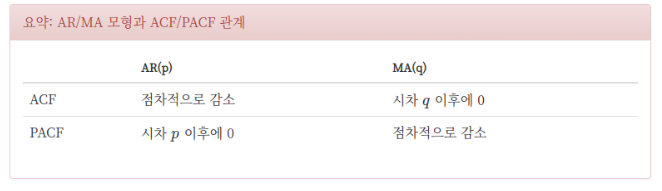

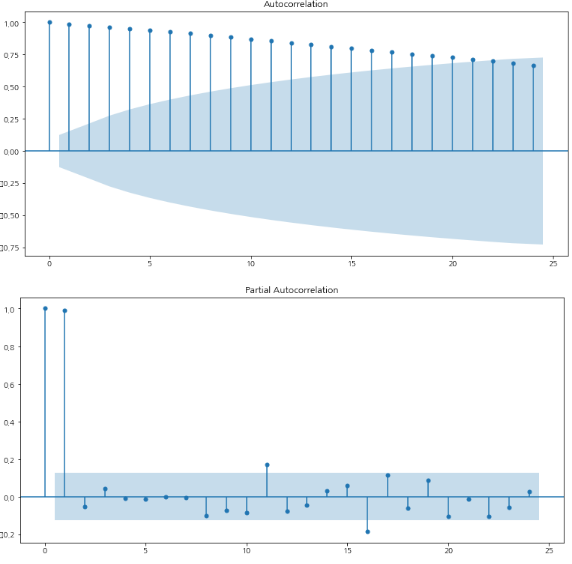

### ARIMA모델에서 (p,d,q) 값 변경
데이터에 받게 각 변수를 할당하는법은 아직 모르겠다. 나중에 시계열데이터를 다른다고 하면 그때 자세히 공부해보자.

# 코드


#### 1.Series 무엇인가?
Pandas에서 제공하는 Series라는 자료구조

#### 2.  날짜를 인덱스로 설정하는법
https://soo-jjeong.tistory.com/127    
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True      
parse_dates는 날짜를 datetime형태로 변환할지 여부     
index_col는 날짜칼럼을 인덱스로 설정하기 위한 것

#### 3. Series자료형 결측치 찾기
ts1[ts1.isna()]     
https://hogni.tistory.com/72

#### 4. Series자료형에 결측치 있는 경우 보간방식 사용
  ( 1과 3 사이에 결측치가 존재한다면 2로 정해준다.)     
ts1.interpolate(method='time') # 보간 기준은 time을 선택

#### 5.def plot_rolling_statistics(timeseries, window=12)
일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수입니다. 현재 타임스텝부터 window에 주어진 타임스텝 이전 사이 구간의 평균(rolling mean, 이동평균)과 표준편차(rolling std, 이동표준편차)를 원본 시계열과 함께 시각화해 보면 좀 더 뚜렷한 경향성을 확인한다.

#### 6. statsmodels 라이브러리 안에는 seasonal_decompose 메소드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있습니다.